# &#128992; Google Colab Setup and Installing Eureka!

**Important:** You will need to re-run these first two cells each time your runtime gets deleted.

&#128992; **This first cell will install Eureka!**

In [ ]:
# Change numpy version (required for theano)
!pip install numpy==1.21.6
# Install Eureka! (for now a dev branch, but in the future a stable branch)
!pip install eureka@git+https://github.com/kevin218/Eureka.git@dev/tjb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.6 which is incompatible.


  Cloning https://github.com/kevin218/Eureka.git (to revision dev/tjb) to /tmp/pip-install-l6oxnjff/eureka_fce069c380e7456db4d7b5959c5a7011
  Running command git clone --filter=blob:none --quiet https://github.com/kevin218/Eureka.git /tmp/pip-install-l6oxnjff/eureka_fce069c380e7456db4d7b5959c5a7011
  Running command git checkout -b dev/tjb --track origin/dev/tjb
  Switched to a new branch 'dev/tjb'
  Branch 'dev/tjb' set up to track remote branch 'dev/tjb' from 'origin'.
  Resolved https://github.com/kevin218/Eureka.git to commit 99c375da1da749c15679805a1c391740e431669d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/kevin218/Astraeus (to revision main) to /tmp/pip-install-l6oxnjff/astraeus_9f4495a29890424d877296b3776f81f0
  Running command git clone --filter=blob:none --quiet https://github.com/kevin218/Astraeus /tmp/pip-install-l6oxnjff/astraeus_9f4495a29890424d877296b3

This next cell will connect your notebook to your Google Drive files.

&#128992; **Run this cell if you are running Google Colab.**

In [ ]:
# You will be prompted to Permit this notebook to access your Google Drive files - Click on "Connect to Google Drive"
# You will then be prompted to Choose an account - click on your preferred Google account
# You will then confirm that Google Drive for desktop wants to access your Google Account - scroll to click "Allow"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


&#128992; **After the cell above outputs "Mounted at /content/drive", click the "Runtime"->"Restart runtime" in the top menu bar, and then you can proceed with the cells below**

In [ ]:
import eureka
import os
import numpy as np

Could not import starry and/or pymc3 related packages. Functionality may be limited.


Next, we will re-use the eventlabel from Workshop #1. The eventlabel is a short, meaningful label (without spaces) that describes the data you're currently working on. For simplicity, simply set `eventlabel = 'miri'`. This same event label should be used throughout all stages.

In [ ]:
eventlabel = 'miri'

# An introduction to Bayesian statistics

*The text discussing Bayesian statistics throughout this notebook is adapted from:*
<blockquote>Bell, Taylor James. "Characterizing Ultra-Hot Jupiters through Theoretical Modelling and Precise Observations." Doctoral Thesis, McGill University, 2021.</blockquote>

<br/>

**This introduction to Bayesian statistics can be skipped if you are already familiar, and you can resume at "Optimizing a fit to the white lightcurve".**

<br/>

This workshop will make heavy use of Bayesian statistics which is a fundamental aspect of most aspects of modern science and data analysis. According to Bayes' theorem, the probability, $P$, of a hypothesis, $H$, given a set of observations, $\mathbf{X}$, and a collection of prior knowledge, $I$, is given by
\begin{equation*}
    P(H|\mathbf{X},I) = \frac{P(\mathbf{X}|H,I) P(H|I)}{P(\mathbf{X}|I)},
\end{equation*}
where $|$ reads as "given" (that all terms to the right are assumed true), and the comma reads as "and". The power of Bayes' theorem is that it allows us to compute the *posterior probability*, $P(H|\mathbf{X},I)$, using the much more easily calculable *likelihood function*, $P(\mathbf{X}|H,I)$, which is the probability that we would have observed the data $\mathbf{X}$ if the hypothesis and prior knowledge were correct. The $P(H|I)$ term is the *prior probability* and summarizes how our prior knowledge affects our hypothesis before having measured the data $\mathbf{X}$. Finally, the $P(\mathbf{X}|I)$ term is the *evidence* or *marginal likelihood* and is often omitted when fitting a model to data as it is only a normalization term and does not depend on the hypothesis.

When fitting a set of observations, a hypothesis typically consists of a function describing the model which depends on a collection of parameters, $\theta$, and hyperparameters, $\alpha$. Bayes' theorem can then be re-written as
\begin{equation*}
    P(\theta|\mathbf{X},\alpha) \propto P(\mathbf{X}|\theta,\alpha) P(\theta|\alpha).
\end{equation*}
Fitting the observations usually starts by freezing the set of hyperparameters and then evaluating the posterior probability by comparing different model predictions to the observed data. Fitting the observations then requires determining the values of $\theta$ that maximize the posterior probability (called the Maximum A Posteriori estimate or MAP estimate), while determining the uncertainty on the model parameters involves determining the range of values of $\theta$ that provide an adequately good fit to the observations (called the confidence interval).

In principle, one could simultaneously estimate the optimal value of $\theta$ and its confidence interval from the posterior probability density function (PDF) by calculating the posterior probability for all values of $\theta$; this is called a grid search. While this technique may be feasible for discrete parameters or low dimensional problems, performing a grid search when the vector $\theta$ contains tens or thousands of continuous variables becomes immensely challenging and computationally inefficient. Instead, various algorithms can be used to compute the MAP estimate and the confidence interval, some of which we will make use of in this workshop.

# Optimizing a fit to the white lightcurve

In this section, we are going to find the MAP (often called "best-fit") model parameter values by fitting a "white" lightcurve using an optimization algorithm. As was discussed in Workshop #1, by "white" we mean wavelength-integrated, where the MIRI wavelengths used here span 5–10.5 micrometers.

Estimating the best-fit values of the parameters $\theta$ is often done using a gradient descent algorithm. This technique starts by picking either a random or partially informed initial estimate for the value of $\theta$ and then computing or estimating the gradient in the posterior PDF depending on whether or not the model is differentiable. In practice, most optimization methods are formulated as minimization routines (hence the name gradient *descent*), so it is more common to seek the minimum of the *negative* posterior probability. The algorithm will then take a small step in the direction in which the posterior probability most rapidly increases and then re-evaluate the gradient in the posterior PDF. This procedure is then repeated (typically with a gradually decreasing step size) until the algorithm locates a local maximum in the posterior PDF. The distinction of a local maximum rather than a global maximum is important as gradient descent routines do not explore the parameter space as thoroughly as a grid search, so it is possible for the algorithm to settle on a local maximum which compares poorly to the global maximum. This is typically overcome by running several gradient descent optimizations initialized at random locations in parameter space in the hopes that one of the optimizations will make its way to the global maximum (or at least alert you to the presence of many local maxima). As we'll see later, the posterior for the fits we'll be making in this workshop is pretty smooth, so we'll just run a single optimization run.

## Setting the Stage 5 "Eureka! Control File" (ECF)

**This determines what will happen during Stage 5**

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S5_template.ecf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

The most important parameters and their recommended settings are described below, but more context can be found on the [Eureka! documentation website](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5).

1. Set the `ncpu` parameter to `1`. Model optimization algorithms can typically only make use of one cpu thread, and since we're running this on Google Colab which only offers one thread there's no benefit to setting it higher.
2. Make sure `rescale_err` is set to `False` - we'll be using a different method of error inflation to ensure that we end up with a reduced chi-squared of unity.
3. Set `verbose` to `True` so you get lots of useful information printed out.
4. Set `fit_method` to `[lsq]` to use the [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) algorithm to **minimize** the **negative** log-probability in order to find the best-fit values for each fitted parameter.
5. Set `run_myfuncs` to `[batman_ecl, sinusoid_pc, polynomial, ypos, ywidth]`. Each element in this list is a function that will be fitted to the data — we'll setup more aspects of each function below when we setup the "Eureka! Parameter File". The `batman_ecl` function uses the [batman](http://lkreidberg.github.io/batman/docs/html/index.html) package to model an eclipse function which describes how the astrophysical flux decreases when we go from seeing the combined light from the star and planet to just the light from the star when the planet is behind the star. The `sinusoid_pc` function models the orbital phase variations of the planet which are caused by the planet having a hot dayside and a cold nightside, so as the planet rotates from our perspective we see different hemispheres of the planet; a good functional approximation of these orbital phase variations is a sine function which has a peak near eclipse (when the hot dayside is pointing toward us) and a trough near transit (when the cold nightside is pointing toward us). The `polynomial` function allows us to fit for systematic trends in time (like a linear slope) as well as fitting for the overall baseline flux level; you must always use a `polynomial` model when fitting observations to at least model the baseline flux level. The `ypos` and `ywidth` functions model changes in the flux caused by changes in the position and PSF width of the spectrum on the detector in the spatial direction; we computed these during Stage 3 in Workshop #1. JWST is quite stable over time, so these functions just assume that the flux is linearly correlated with the spatial position and PSF width. Not all observations require that you use the `ypos` and `ywidth` functions, but they're often useful for MIRI observations.
6. Set `fit_par` to `./S5_fit_par_template.epf`. This tells Eureka! where you have specified the priors and initial guesses for the parameters the control the functions listed above.
7. Set `manual_clip` to `None` since we don't need to manually remove any integrations from these data.
8. Set `force_positivity` to `True`. This will be discussed in more detail below when setting up the EPF file.
9. Leave all parameters under the "Limb darkening controls" heading at their default values of `None` since we're fitting an eclipse observation and stellar limb darkening has no impact on eclipse observations.
10. Set `lsq_method` to `Powell`. This controls which scipy.optimize.minimize optimization method will be used. In general, the Powell algorithm works very well.
11. Set `lsq_tol` to `1e-6`. This sets the error tolerance for the scipy.optimize.minimize optimization method, where a smaller value will result in a more precise estimate of the "best-fit" value, so long as the optimizer manages to converge. A value of `1e-6` will suffice for most datasets.
12. Leave `lsq_maxiter` at its default setting of `None`. This parameter can be used to let the optimzation routine run for longer if you get a message saying that the fit failed because the maximum number of function evaluations has been exceeded. This can sometimes happen when `lsq_tol` is set too small, when you're fitting a complex model with many parameters, or when there are strong degeneracies between two or more parameters.
13. For now, you can safely ignore all of the settings related to the dynesty, emcee, and nuts sampling algorithms - we'll come back to these later.
14. Set `isplots_S5` to `5` so that you see lots of useful plots that can help you debug your fits.
15. Set `nbin_plot` to `None` since we're not fitting that many integrations and we don't really need to temporally bin the data when plotting to be able to see our astrophysical signal.
16. Set `hide_plots` to `False` so that all your figures appear within the notebook (you can set this to `True` if you're running the code from the terminal and want to avoid an excessive number of pop-ups appearing).
17. &#128992; Set `topdir` to the folder containing your input "white" Stage 4 folder. This should start with /content/drive/MyDrive/ (this is where your Google Drive files get mounted) and then specify the folder structure you setup. For example, if your Stage4_white files on Google Drive are in SSW2023→MIRI→Stage4_white, then set `topdir` to `/content/drive/MyDrive/SSW2023/MIRI`. &#128309; If you are using the Jupyter notebook, set `topdir` to the full parent directory of the input "white" Stage4 directory.
18.  Since we're fitting white lightcurves, we'll adjust the `inputdir` to `Stage4_white/S4_2023-06-02_miri_run1` and the `outputdir` to `Stage5_white`. This `inputdir` setting will use our provided Stage 4 output files, but if you want to try using your own results from Workshop #1, you can instead set `intputdir` to `Stage4_white` to use your most recent Stage4_white result or you can choose a specific run using the syntax `Stage4_white/S4_YYYY-MM-DD_miri_runN` where YYYY is the year (e.g., `2023`), MM is the month (e.g., `07`), DD is the day (e.g., `24`), and N is the particular run number that you want to use (e.g., `1`).

In [ ]:
s5_ecf_contents = f"""
# Eureka! Control File for Stage 5: Lightcurve Fitting

# Stage 5 Documentation: https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5

ncpu            1 # The number of CPU threads to use when running emcee or dynesty in parallel

allapers        False                   # Run S5 on all of the apertures considered in S4? Otherwise will use newest output in the inputdir
rescale_err     False                   # Rescale uncertainties to have reduced chi-squared of unity
fit_par         ./S5_fit_par_template.epf   # What fitting epf do you want to use?
verbose         True                    # If True, more details will be printed about steps
fit_method      [lsq]              #options are: lsq, emcee, dynesty (can list multiple types separated by commas)
run_myfuncs     [batman_ecl, sinusoid_pc, polynomial, ypos, ywidth]   # options are: batman_tr, batman_ecl, sinusoid_pc, expramp, polynomial, step, xpos, ypos, xwidth, ywidth, and GP (can list multiple types separated by commas)

# Manual clipping in time
manual_clip     None    # A list of lists specifying the start and end integration numbers for manual removal.
force_positivity   True
# Limb darkening controls
# IMPORTANT: limb-darkening coefficients are not automatically fixed then, change to 'fixed' in .epf file whether they should be fixed or fitted!
use_generate_ld  None  # use the generated limb-darkening coefficients from Stage 4? Options: exotic-ld, None. For exotic-ld, the limb-darkening laws available are linear, quadratic, 3-parameter and 4-parameter non-linear.
ld_file          None  # Fully qualified path to the location of a limb darkening file that you want to use
ld_file_white    None  # Fully qualified path to the location of a limb darkening file that you want to use for the white-light light curve (required if ld_file is not None and any EPF parameters are set to white_free or white_fixed).

# General fitter
old_fitparams   None # filename relative to topdir that points to a fitparams csv to resume where you left off (set to None to start from scratch)

#lsq
lsq_method      'Powell' # The scipy.optimize.minimize optimization method to use
lsq_tol         1e-6    # The tolerance for the scipy.optimize.minimize optimization method
lsq_maxiter     None    # Maximum number of iterations to perform. Depending on the method each iteration may use several function evaluations. Set to None to use the default value

#mcmc
old_chain       None    # Output folder relative to topdir that contains an old emcee chain to resume where you left off (set to None to start from scratch)
lsq_first       True    # Initialize with an initial lsq call (can help shorten burn-in, but turn off if lsq fails). Only used if old_chain is None
run_nsteps      1000
run_nwalkers    200
run_nburn       500     # How many of run_nsteps should be discarded as burn-in steps

#dynesty
run_nlive       1024    # Must be > ndim * (ndim + 1) // 2
run_bound       'multi'
run_sample      'auto'
run_tol         0.1

#GP inputs
kernel_inputs   ['time'] #options: time
kernel_class    ['Matern32'] #options: ExpSquared, Matern32, Exp, RationalQuadratic for george, Matern32 for celerite (sums of kernels possible for george separated by commas)
GP_package      'celerite' #options: george, celerite

# Plotting controls
interp          False   # Should astrophysical model be interpolated (useful for uneven sampling like that from HST)

# Diagnostics
isplots_S5      5       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nbin_plot       None     # The number of bins that should be used for figures 5104 and 5304. Defaults to 100.
testing_S5      False   # Boolean, set True to only use the first spectral channel
testing_model   False   # Boolean, set True to only inject a model source of systematics
hide_plots      False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir          /content/drive/MyDrive/SSW2023/MIRI

# Directories relative to topdir
inputdir        Stage4_/S4_2023-07-24_miri_run1   # The folder containing the outputs from Eureka!'s S4 pipeline (will be overwritten if calling S4 and S5 sequentially)
outputdir       Stage5_white
# Fill this text block with the contents of the S5 ECF template from https://github.com/kevin218/Eureka/tree/main/demos/JWST
# and then adjust the values as described above

"""

with open(f'S5_{eventlabel}.ecf', 'w') as f:
    f.write(s5_ecf_contents)

## Setting the Stage 5 "Eureka! Parameter File" (EPF)

**This determines the priors and starting guesses for your fitted models**

Here is where we dive further into specifying details about the models that we want to fit to our data. We'll discuss the ones relevant to this fit below, but more details can be found on the [Eureka documentation webpage](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5-fit-parameters).

Each row has 6 columns:
> `Name Value Free? PriorPar1 PriorPar2 PriorType`

`Name` specifies the name of a fitted variable. These have to be from a very specific list of options so that Eureka! knows what the variable is supposed to mean. For example `rp` is the planet-to-star radius ratio (so `rp` squared would be equal to the transit depth) and `fp` is the eclipse depth.

`Value` specifies the starting guess for the variable. This column is used for all optimization or sampling algorithms except dynesty which does not take a starting guess. In general, starting guesses do not need to be exceptionally good, and as long as they're in the vague ballpark then the fitting or sampling algorithm should work fine. For fixed parameters (see the description of `Free?` below), this column sets the value of the parameter.

`Free?` specifies whether the parameter should be freely fitted for each wavelength (`'free'`), should be set to a fixed value and not changed throughout the fit (`'fixed'`), is an auxilliary variable that also should not be fit (`'independent'`). Other more advanced options also exist, but we won't cover them here. For fixed and independent variables, the remaining three columns are not used.

**The rightmost column**, `PriorType`, determines what type of prior function you will use to constrain your fitted parameters. The three options are Normal (`N`; also known as a Gaussian prior), Uniform (`U`), and Log-Uniform (`LU`). Some sampling algorithms work faster or more efficiently with Normal priors, but sometimes you must use Uniform priors to avoid unphysical parameter settings. Normal priors are typically best for orbital parameters for which there are published best-fit values and uncertainties.

The meanings of the `PriorPar1` and `PriorPar2` columns are dependent on the setting of the `PriorType` column (which is the last column). If `PriorType` is N, then `PriorPar1` is the mean of the Gaussian prior and `PriorPar2` is the standard deviation. If `PriorType` is U, then `PriorPar1` is the lower limit of the parameter and `PriorPar2` is the upper limit of the parameter. If `PriorType` is LU, then `PriorPar1` is the lower limit of the log of the parameter, and `PriorPar2` is the upper limit of the log of the parameter.


<br/>

---

<br/>


For your fit, you will need the following variables: `rp`, `fp`, `AmpCos1`, `AmpCos2`, `per`, `t0`, `time_offset`, `inc`, `a`, `ecc`, `w`, `c0`, `c1`, `ypos`, `ywidth`, `scatter_mult`, and `Rs`.

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S5_fit_par_template.epf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

- For `per` (planetary orbital period), `t0` (time of conjunction; also called linear ephemeris or transit midpoint), `inc` (planetary orbital inclination), `a` (planetary orbital semi-major axis), `ecc` (planetary orbital eccentricity), and `w` (planetary orbital argument of periastron) we will make use of previously published research. Navigate to the [NASA Exoplanet Archive's page](https://exoplanetarchive.ipac.caltech.edu/overview/WASP-43b) about our target WASP-43b and click on "WASP-43 b Planetary Parameters". We will use the values published by Bonomo et al. 2017 as priors. Where there are two values for the uncertainty, just use the larger of the two. Also, while the published `t0` is in units of BJD_TDB, JWST timestamps are in units of B**M**JD_TDB, where the M means "modified" and BMJD_TDB=BJD_TDB-2400000.5; this removes the first two digits that won't change in our lifetime and changes the time so that a new BMJD_TDB day starts at midnight (while new BJD_TDB days inconventiently start at noon). So we will need to subtract that 2400000.5 from the published `t0` value when entering it into your EPF. And since the planet is consistent with a zero-eccentricity orbit, let's set `ecc` to be fixed to 0 and arbitrarily set `w` to be fixed to 90 (the value of `w` doesn't matter if the eccentricity is zero). In summary, you should have:
> `per 0.81347437 'free' 0.81347437 0.00000013 N`<br/>
> `t0 55934.292239 'free' 55934.292239 0.000040 N`<br/>
> `inc 82.33 'free' 82.33 0.20 N`<br/>
> `a 4.93 'free' 4.93 0.10 N`<br/>
> `ecc 0 'fixed'`<br/>
> `w 90 'fixed'`<br/>

- For `Rs` (the stellar radius in units of Solar radii), we can again use the [NASA Exoplanet Archive's page](https://exoplanetarchive.ipac.caltech.edu/overview/WASP-43b) about WASP-43, this time instead clicking on the "WASP-43 Stellar Parameters" section. This parameter is only used to account for the finite speed of light, so simply fixing it to the published value from Bonomo et al. 2017 will work:
> `Rs 0.667 'fixed'`

- For rp (planet-to-star radius ratio), we'll use the radius I fitted from an earlier part of these data where the planet transited. Please set `rp` to be fixed to a value of 0.15738. Without this knowledge, one could also compute the planet-to-star radius ratio from the planet and star radii published by Bonomo et al. 2017, although care would need to be taken to ensure units were properly accounted for. In summary, set:
> `rp 0.15738 'fixed'`

- Leave time_offset at it's default settings of:
> `time_offset 0 'independent'`.

- For `fp` (eclipse depth), `AmpCos1` (part of the `sinusoid_pc` model which controls the flux difference between the dayside and the nightside), and `AmpSin1` (part of the `sinusoid_pc` model which controls the flux difference between the eastern and western hemispheres) we will have to create some "minimally informative priors". With these priors, we seek to constrain the model to the very rough area that we expect for the parameters while minimally influencing the final results with our semi-arbitrary decision. For `fp`, a visual inspection of the lightcurve suggests that the eclipse depth is around 6000 ppm, so a reasonable, "minimally informative" prior could be $6000 \pm 5000$ ppm which would be specified as:
  > `fp 6000e-6 'free' 6000e-6 5000e-6 N`

  where `6000e-6` is a more conventient way of specifying 6000 ppm than carefully counting decimal places and specifying `0.006` (although both options are possible). For AmpCos1 and AmpSin1, the priors are a bit harder to guess. However, it can be shown that all physically possible phase variations have $\sqrt{{\rm AmpCos1}^2 + {\rm AmpSin1}^2} < 1$. So one prior could be that `-1 < AmpCos1 < 1` and `-1 < AmpSin1 < 1`; however, this still leaves room for non-physical solutions because larger values of one parameter can require smaller values for the other. Thankfully Eureka! has a way of enforcing physical lightcurves, and we already did that above when we set the `force_positivity` parameter to `True` in the Stage 5 ECF. So reasonable, minimally informative priors for both parameters would be:
  > `AmpCos1 0 'free' -1 1 U`<br/>
  > `AmpSin1 0 'free' -1 1 U`

- Our systematics models are controlled by
  - `c0` (the baseline flux level) and `c1` (which fits for a linear slope as a function of time). These two parameters control the `polynomial` function we specified in the ECF settings above. To make things easier, Eureka! normalizes the lightcurves by the median flux, so the value of `c0` should be approximately 1. The value of `c1` is in the units of change in `c0` per day, and is typically very small (the absolute value of `c1` is typically at or below 0.001. Reasonable, minimally informative priors could then be:
  > `c0 1 'free' 1 0.001 N`<br/>
  > `c1 0 'free' 0 0.01 N`
  - `ypos` which assumes the observed flux varies linearly with the position on the detector. This can happen because of flux lost outside of our extraction aperture or between gaps between pixels. Values for `ypos` are typically well below 1, so a reasonable, minimally informative prior could then be:
  > `ypos 0 'free' 0 0.1 N`
  - and `ywidth` which assumes the observed flux varies linearly with the PSF width of the spectrum. This can happen because of flux lost outside of our extraction aperture or between gaps between pixels. Values for `ywidth` can sometimes reach as high as ~1, so a reasonable, minimally informative prior could then be:
  > `ywidth 0 'free' 0 10 N`

- We also need to setup `scatter_mult`. Eureka! estimates the expected level of noise from photon-limited statistics, but data is imperfect and we rarely ever reach the photon-limited noise level (because of background noise, read noise, and other systematic noise sources). If you fit data with underestimated error bars, then the resulting confidence intervals can be artificially small, so we want to inflate the error bars on our observations as is justified by the data. The simplest way to do this with Eureka! is the `scatter_mult` parameter which multiplies the error bars by a constant factor. A fitted value of 2 for `scatter_mult` would mean that the observed scatter in the data is twice as high as it would be in the photon-limited noise regime. MIRI data is typically pretty well behaved though, and a reasonable, minimally informative prior could be:
> `scatter_mult 1.1 'free' 1.1 2 N`

**Finally, delete or comment-out (with `#`) all other parameters not mentioned above.**

In [ ]:
s5_epf_contents = f"""
# Stage 5 Fit Parameters Documentation: https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5-fit-parameters


# Name       Value         Free?          PriorPar1    PriorPar2    PriorType
# "Free?" can be free, fixed, white_free, white_fixed, shared, or independent
# PriorType can be U (Uniform), LU (Log Uniform), or N (Normal).
# If U/LU, PriorPar1 and PriorPar2 represent upper and lower limits of the parameter/log(the parameter).
# If N, PriorPar1 is the mean and PriorPar2 is the standard deviation of a Gaussian prior.
#-------------------------------------------------------------------------------------------------------
#
# ------------------
# ** Transit/eclipse parameters **
# ------------------
Rs 0.667 'fixed'
rp 0.15738 'fixed'
time_offset 0 'independent'

fp 6000e-6 'free' 6000e-6 5000e-6 N

# ----------------------
# ** Phase curve parameters **
# ----------------------
AmpCos1 0 'free' -1 1 U
AmpSin1 0 'free' -1 1 U

#AmpCos2      0.01          'free'         -1           1            U
#AmpSin2      0.01          'free'         -1           1            U
# ------------------
# ** Orbital parameters **
# ------------------
per 0.81347437 'free' 0.81347437 0.00000013 N
t0 55934.292239 'free' 55934.292239 0.000040 N
inc 82.33 'free' 82.33 0.20 N
a 4.93 'free' 4.93 0.10 N
ecc 0 'fixed'
w 90 'fixed'

# -------------------------
# ** Limb darkening parameters **
# Choose limb_dark from ['uniform', 'linear', 'quadratic', 'kipping2013', 'squareroot', 'logarithmic', 'exponential','3-parameter', '4-parameter']
# When using generated limb-darkening coefficients from exotic-ld choose from ['linear', 'quadratic', '3-parameter', '4-parameter']
# -------------------------
limb_dark    'kipping2013'  'independent'
u1           0.59           'free'         0            1            U
u2           0.84           'free'         0            1            U
# --------------------
# ** Systematic variables **
# Polynomial model variables (c0--c9 for 0th--3rd order polynomials in time); Fitting at least c0 is very strongly recommended!
# Exponential ramp model variables (r0--r2 for one exponential ramp, r3--r5 for a second exponential ramp)
# GP model parameters (A, WN, m1, m2) in log scale
# Step-function model variables (step# and steptime# for step-function model #; e.g. step0 and steptime0)
# Drift model variables (xpos, ypos, xwidth, ywidth)
ypos 0 'free' 0 0.1 N
ywidth 0 'free' 0 10 N

# --------------------
c0 1 'free' 1 0.001 N
c1 0 'free' 0 0.01 N

#A            -5             'free'         -20.         -5.          U
#WN           -15            'free'         -20.         -10.         U
#m1           -5             'free'         -10.         0.           U
# -----------
# ** White noise **
# Use scatter_mult to fit a multiplier to the expected noise level from Stage 3 (recommended)
# Use scatter_ppm to fit the noise level in ppm
# Use WN parameter in GP model parameters to account for white noise in the GP model
# -----------
scatter_mult 1.1 'free' 1.1 2 N

# Fill this text block with the contents of the S5 EPF template from https://github.com/kevin218/Eureka/tree/main/demos/JWST
# and then adjust the values as described above

"""

with open('S5_fit_par_template.epf', 'w') as f:
    f.write(s5_epf_contents)

## Running Eureka!'s Stage 5

The following cell will run Eureka!'s Stage 5 using the settings you defined above. Note that your ECF and EPF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The following fit should take &lt;1 minute to complete on Google Colab.

Finished loading parameters from /content/drive/MyDrive/SSW2023/MIRI/Stage4_/S4_2023-07-24_miri_run1/ap6_bg12//S4_miri_ap6_bg12_LCData.h5

Starting Stage 5: Light Curve Fitting

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage4_/S4_2023-07-24_miri_run1/ap6_bg12/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage5_white/S5_2023-07-26_miri_run5/ap6_bg12/
Copying S5 control file
Copying S5 parameter control file

Starting Channel 1 of 1

Starting lsq fit.
Starting lnprob: -98798.42889356789


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Current lnprob =  8123.957280441673
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -8123.957280441673
       x: [ 5.743e-03  4.742e-01 ... -7.187e-04  1.186e+00]
     nit: 19
   direc: [[-9.776e-06 -1.405e-02 ... -3.127e-03 -2.494e-02]
           [-7.651e-05 -1.568e-02 ... -3.225e-03 -1.228e-02]
           ...
           [ 2.109e-04  4.555e-01 ... -1.004e-03 -1.420e-01]
           [ 9.592e-06  8.414e-03 ... -4.274e-04  5.612e-03]]
    nfev: 5137

Ending lnprob: 8123.957280441673
Reduced Chi-squared: 1.010155629427539

LSQ RESULTS:
fp: 0.005743261011062258
AmpCos1: 0.4741854513309698
AmpSin1: -0.06954548454346798
per: 0.8134740941439479
t0: 55934.29223359929
inc: 82.56985299716659
a: 4.94151763177653
u1: 0.5900000032007414
u2: 0.8399999967992585
ypos: 0.0027009285546640348
ywidth: 0.0001510836015869378
c0: 0.9960053488865138
c1: -0.0007186946627720581
scatter_mult: 1.1862425668335312; 364.11847751530286 ppm



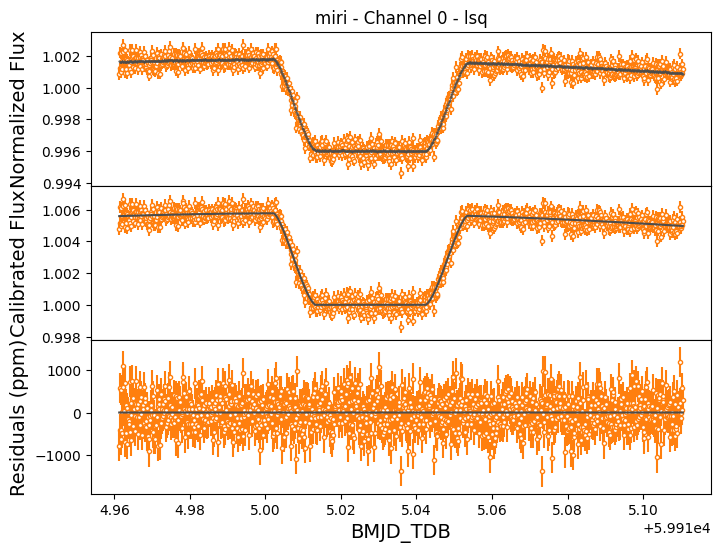

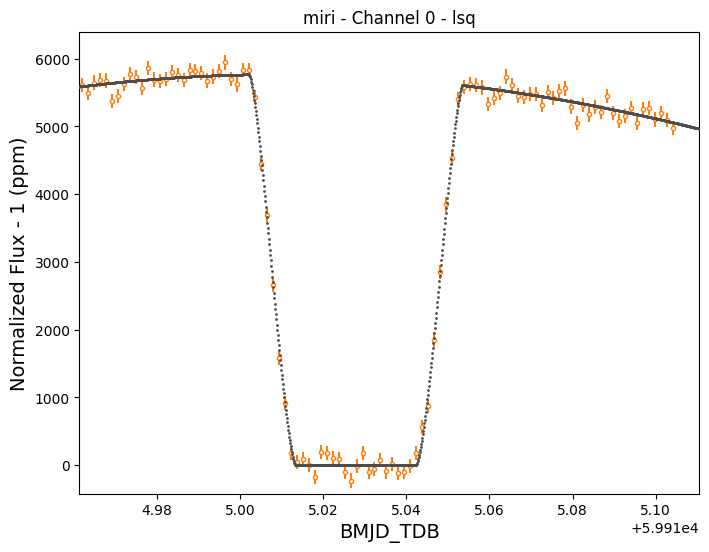

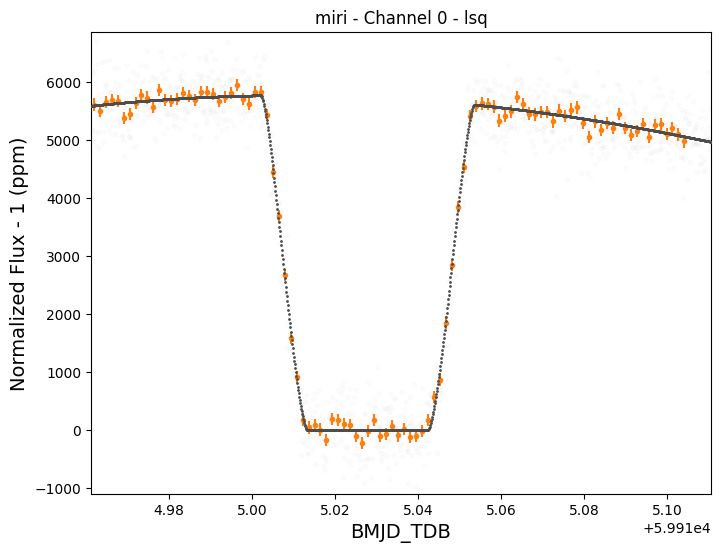

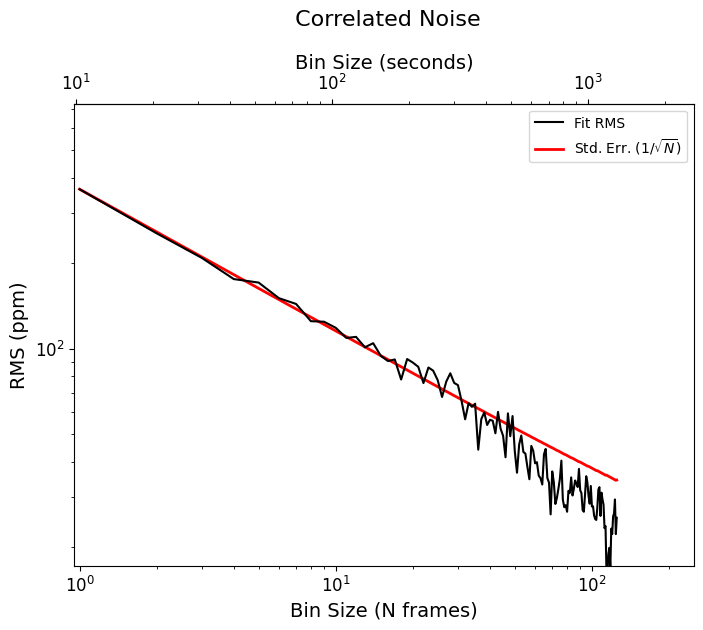

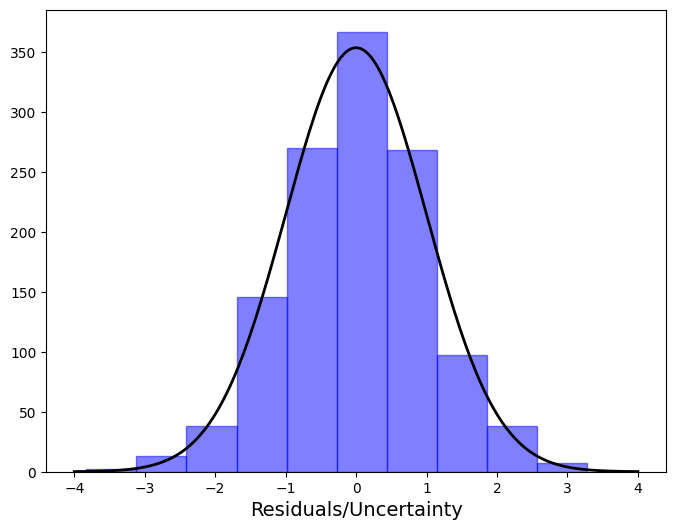

Completed lsq fit.
-------------------------


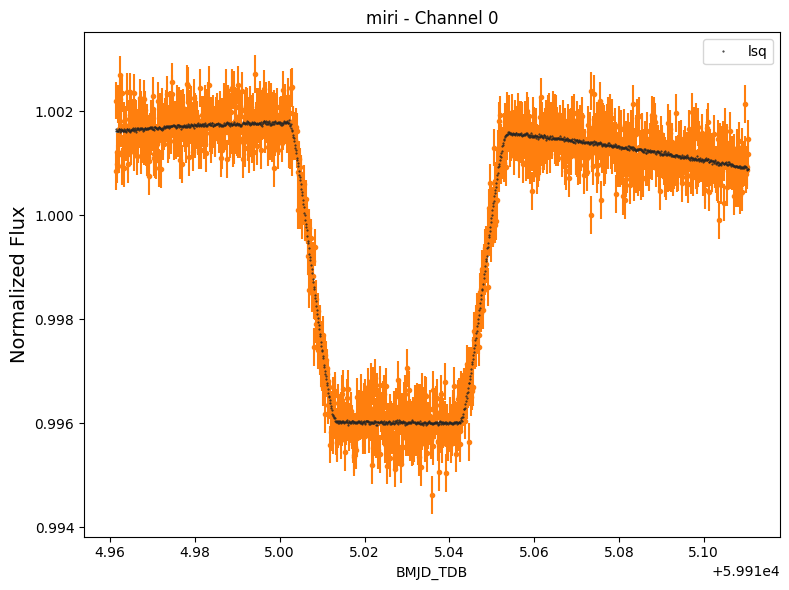

Saving results

Total time (min): 0.45


In [ ]:
s5_meta = eureka.S5_lightcurve_fitting.s5_fit.fitlc(eventlabel)

# Sampling white lightcurve posterior

Estimating the confidence interval of our parameters $\theta$ could be done by extrapolating the posterior PDF from the MAP value using the first and second order gradient and then determining the extent to which each component of $\theta$ can be changed while still providing an adequately good fit to the observations. However, this technique can give inaccurate estimates especially in the presence of correlations between different parameters. Instead, a sampling algorithm like the Markov Chain Monte-Carlo (MCMC) method is typically used to estimate parameter uncertainties. Monte-Carlo (MC) methods in general involve randomly sampling values of $\theta$, while MCMCs are a specific variant where samples are randomly drawn based on the knowledge of the posterior probability from the previously drawn value; the draws of MCMC are typically called steps taken by a walker, and a collection of many walker steps are called a chain.

One increasingly popular sampling algorithm is called [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) which does not necessarily use a MCMC method. Nested sampling can be difficult to explain intuitively, but one of the nice advantages to nested sampling is that it can be used for model comparison. More relevant to our purposes here, the [dynesty](https://dynesty.readthedocs.io/en/stable/) dynamic nested sampling algorithm is able to quickly sample our posterior and has a convenient stopping condition which ensures the sampler has converged so that we get reliable uncertainties.

## Adjusting the Stage 5 "Eureka! Control File" (ECF)

Thankfully we can reuse the vast majority of our ECF settings above with only a few minor tweaks.

To begin, please first copy below the contents of the ECF that you filled out above. Then:

1. Change `fit_method` to be `[dynesty]` to instead use the dynesty sampler.
2. Add the following dynesty-related settings
  1. Set `run_nlive` to `121`. This sets the number of "live" points that dynesty will use (for more details see [here](https://dynesty.readthedocs.io/en/stable/faq.html#live-point-questions)). For reliable results, this must be greater than `ndim * (ndim + 1) // 2`, where `ndim` is the number of fitted parameters and `//` indicates integer division. In general, the larger this number the more robust your results will be and the longer they will take to run. A value of `121` is a fairly reasonable balance of speed and quality.
  2. Set `run_bound` to `'multi'`. This sets the type of bounds used by dynesty to "multiple ellipsoid decomposition". For more information, see [here](https://dynesty.readthedocs.io/en/stable/faq.html#bounding-questions). A value of `'multi'` should work for most problems.
  3. Set `run_sample` to `'auto'`. This lets dynesty choose the optimal sampling method based on the number of fitted parameters, and `auto` is a safe bet for most problems. For more information, see [here](https://dynesty.readthedocs.io/en/stable/faq.html#sampling-questions).
  4. Finally, set `run_tol` to `0.1`. This determines the stopping condition of the sampler. Smaller values will result in more precise posteriors at the cost of increased runtime, while larger values can result in poorly converged garbage. In general, a value of `0.1` should work for most problems.

In [ ]:
s5_ecf_contents = f"""
# Eureka! Control File for Stage 5: Lightcurve Fitting

# Stage 5 Documentation: https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5

ncpu            1 # The number of CPU threads to use when running emcee or dynesty in parallel

allapers        False                   # Run S5 on all of the apertures considered in S4? Otherwise will use newest output in the inputdir
rescale_err     False                   # Rescale uncertainties to have reduced chi-squared of unity
fit_par         ./S5_fit_par_template.epf   # What fitting epf do you want to use?
verbose         True                    # If True, more details will be printed about steps
fit_method      [dynesty]             #options are: lsq, emcee, dynesty (can list multiple types separated by commas)
run_myfuncs     [batman_ecl, sinusoid_pc, polynomial, ypos, ywidth]   # options are: batman_tr, batman_ecl, sinusoid_pc, expramp, polynomial, step, xpos, ypos, xwidth, ywidth, and GP (can list multiple types separated by commas)

# Manual clipping in time
manual_clip     None    # A list of lists specifying the start and end integration numbers for manual removal.
force_positivity   True
# Limb darkening controls
# IMPORTANT: limb-darkening coefficients are not automatically fixed then, change to 'fixed' in .epf file whether they should be fixed or fitted!
use_generate_ld  None  # use the generated limb-darkening coefficients from Stage 4? Options: exotic-ld, None. For exotic-ld, the limb-darkening laws available are linear, quadratic, 3-parameter and 4-parameter non-linear.
ld_file          None  # Fully qualified path to the location of a limb darkening file that you want to use
ld_file_white    None  # Fully qualified path to the location of a limb darkening file that you want to use for the white-light light curve (required if ld_file is not None and any EPF parameters are set to white_free or white_fixed).

# General fitter
old_fitparams   None # filename relative to topdir that points to a fitparams csv to resume where you left off (set to None to start from scratch)

#lsq
lsq_method      'Powell' # The scipy.optimize.minimize optimization method to use
lsq_tol         1e-6    # The tolerance for the scipy.optimize.minimize optimization method
lsq_maxiter     None    # Maximum number of iterations to perform. Depending on the method each iteration may use several function evaluations. Set to None to use the default value

#mcmc
old_chain       None    # Output folder relative to topdir that contains an old emcee chain to resume where you left off (set to None to start from scratch)
lsq_first       True    # Initialize with an initial lsq call (can help shorten burn-in, but turn off if lsq fails). Only used if old_chain is None
run_nsteps      1000
run_nwalkers    200
run_nburn       500     # How many of run_nsteps should be discarded as burn-in steps

#dynesty
run_nlive       121    # Must be > ndim * (ndim + 1) // 2
run_bound       'multi'
run_sample      'auto'
run_tol         0.1

#GP inputs
kernel_inputs   ['time'] #options: time
kernel_class    ['Matern32'] #options: ExpSquared, Matern32, Exp, RationalQuadratic for george, Matern32 for celerite (sums of kernels possible for george separated by commas)
GP_package      'celerite' #options: george, celerite

# Plotting controls
interp          False   # Should astrophysical model be interpolated (useful for uneven sampling like that from HST)

# Diagnostics
isplots_S5      5       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nbin_plot       None     # The number of bins that should be used for figures 5104 and 5304. Defaults to 100.
testing_S5      False   # Boolean, set True to only use the first spectral channel
testing_model   False   # Boolean, set True to only inject a model source of systematics
hide_plots      False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir          /content/drive/MyDrive/SSW2023/MIRI

# Directories relative to topdir
inputdir        Stage4_/S4_2023-07-24_miri_run1   # The folder containing the outputs from Eureka!'s S4 pipeline (will be overwritten if calling S4 and S5 sequentially)
outputdir       Stage5_white

# Fill this text block with the contents of your S5 ECF from above,
# and then adjust the values as described above

"""

with open(f'S5_{eventlabel}.ecf', 'w') as f:
    f.write(s5_ecf_contents)

## Running Eureka!'s Stage 5

Because we want to use the exact same model and priors as our previous optimization run, there is no need to update our EPF and the code will just re-use the one we made above.

The following cell will run Eureka!'s Stage 5 using the settings you defined above. Note that your ECF and EPF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The following fit should take ~15 minutes to complete on Google Colab. While waiting for the fits to complete, you could begin setting up the next section.

Finished loading parameters from /content/drive/MyDrive/SSW2023/MIRI/Stage4_/S4_2023-07-24_miri_run1/ap6_bg12//S4_miri_ap6_bg12_LCData.h5

Starting Stage 5: Light Curve Fitting

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage4_/S4_2023-07-24_miri_run1/ap6_bg12/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage5_white/S5_2023-07-26_miri_run6/ap6_bg12/
Copying S5 control file
Copying S5 parameter control file

Starting Channel 1 of 1

Starting dynesty fit.
Starting lnprob: -98798.42889356789
Running dynesty...


6814it [13:56,  8.14it/s, +121 | bound: 340 | nc: 1 | ncall: 221447 | eff(%):  3.133 | loglstar:   -inf < 8097.710 <    inf | logz: 8043.879 +/-    nan | dlogz:  0.001 >  0.100]


Summary
nlive: 121
niter: 6814
ncall: 221326
eff(%):  3.133
logz: 8043.879 +/-  0.714

Number of posterior samples is 6935


Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage5_white/S5_2023-07-26_miri_run6/ap6_bg12/S5_dynesty_samples_ch0.h5
Ending lnprob: 8123.787141496236
Reduced Chi-squared: 1.0020900943527917

DYNESTY RESULTS:
fp: 0.005736317766365173 (+3.542974778138197e-05, -3.490241095694107e-05)
AmpCos1: 0.455857328690916 (+0.053360115931758045, -0.04895969780388598)
AmpSin1: -0.06745024294962931 (+0.05363852622676411, -0.053088413638288756)
per: 0.8134740941512996 (+1.4013741722607165e-08, -1.4409344273325075e-08)
t0: 55934.29223745282 (+3.45590160577558e-05, -3.844006278086454e-05)
inc: 82.56991497629944 (+0.1393895006512338, -0.1326404272434729)
a: 4.944354835507415 (+0.03624818455204881, -0.035719065779140635)
u1: 0.5651059346150459 (+0.3042283797513241, -0.3586008466534742)
u2: 0.5435459872610939 (+0.28698153772269286, -0.3482316211254265)
ypos: 0.002378027599657638 (+0.0014023128611379801, -0.0013467224108890876)
ywidth: 0.00036104382808487716 (+0.0016994189780835125, -0.001890248351

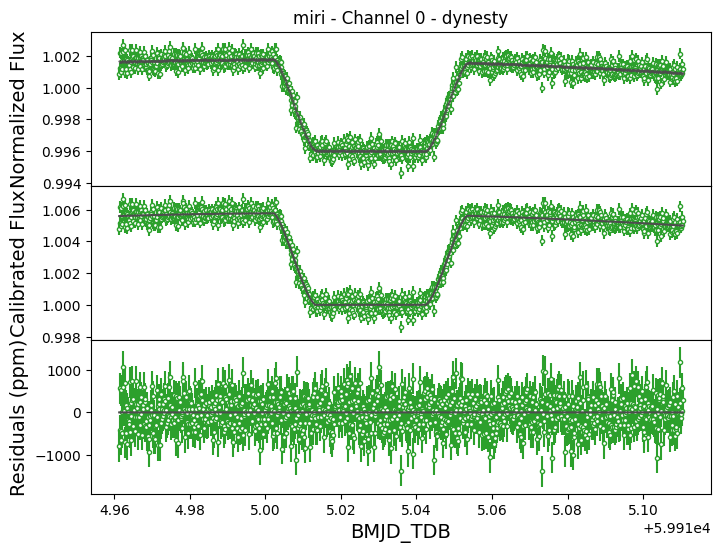

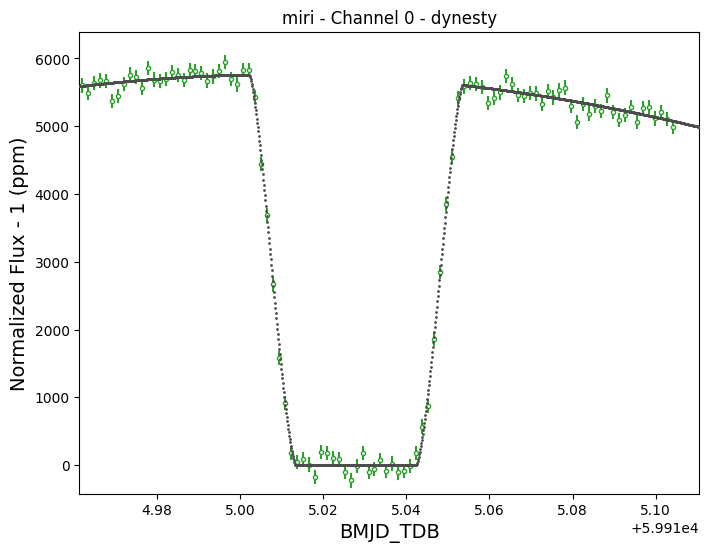

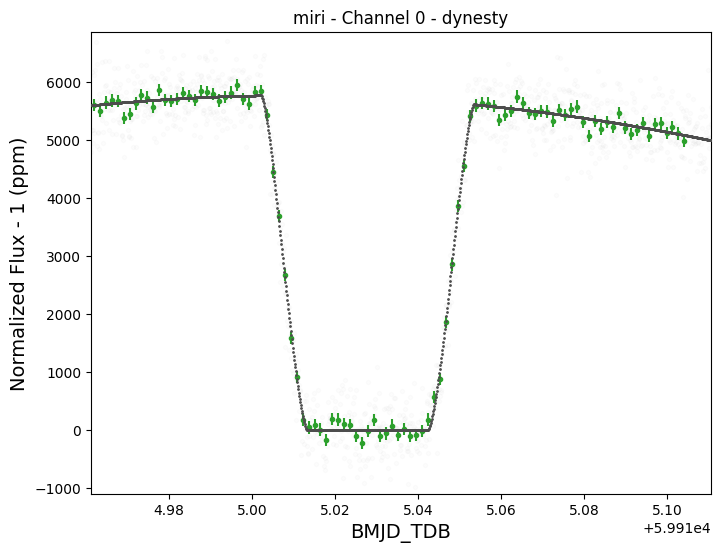

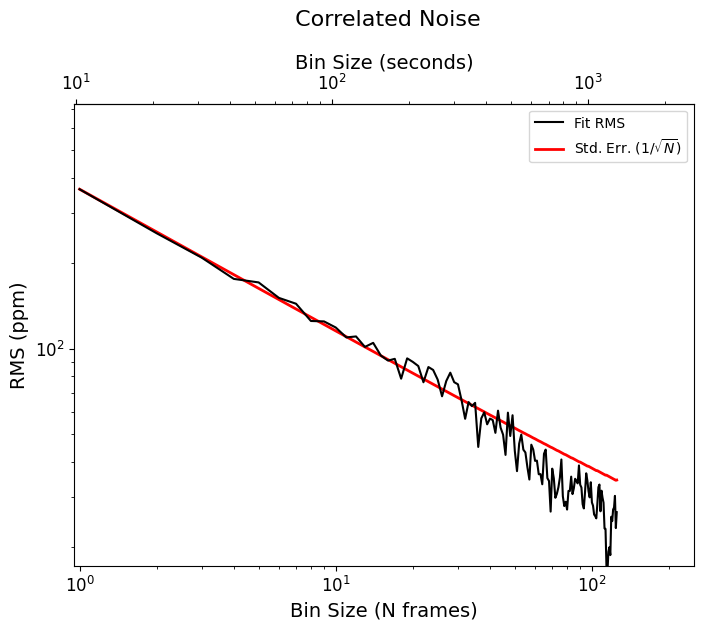

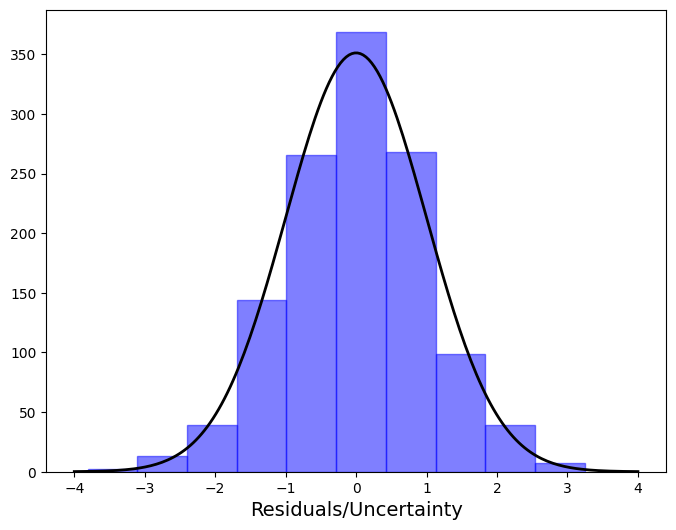

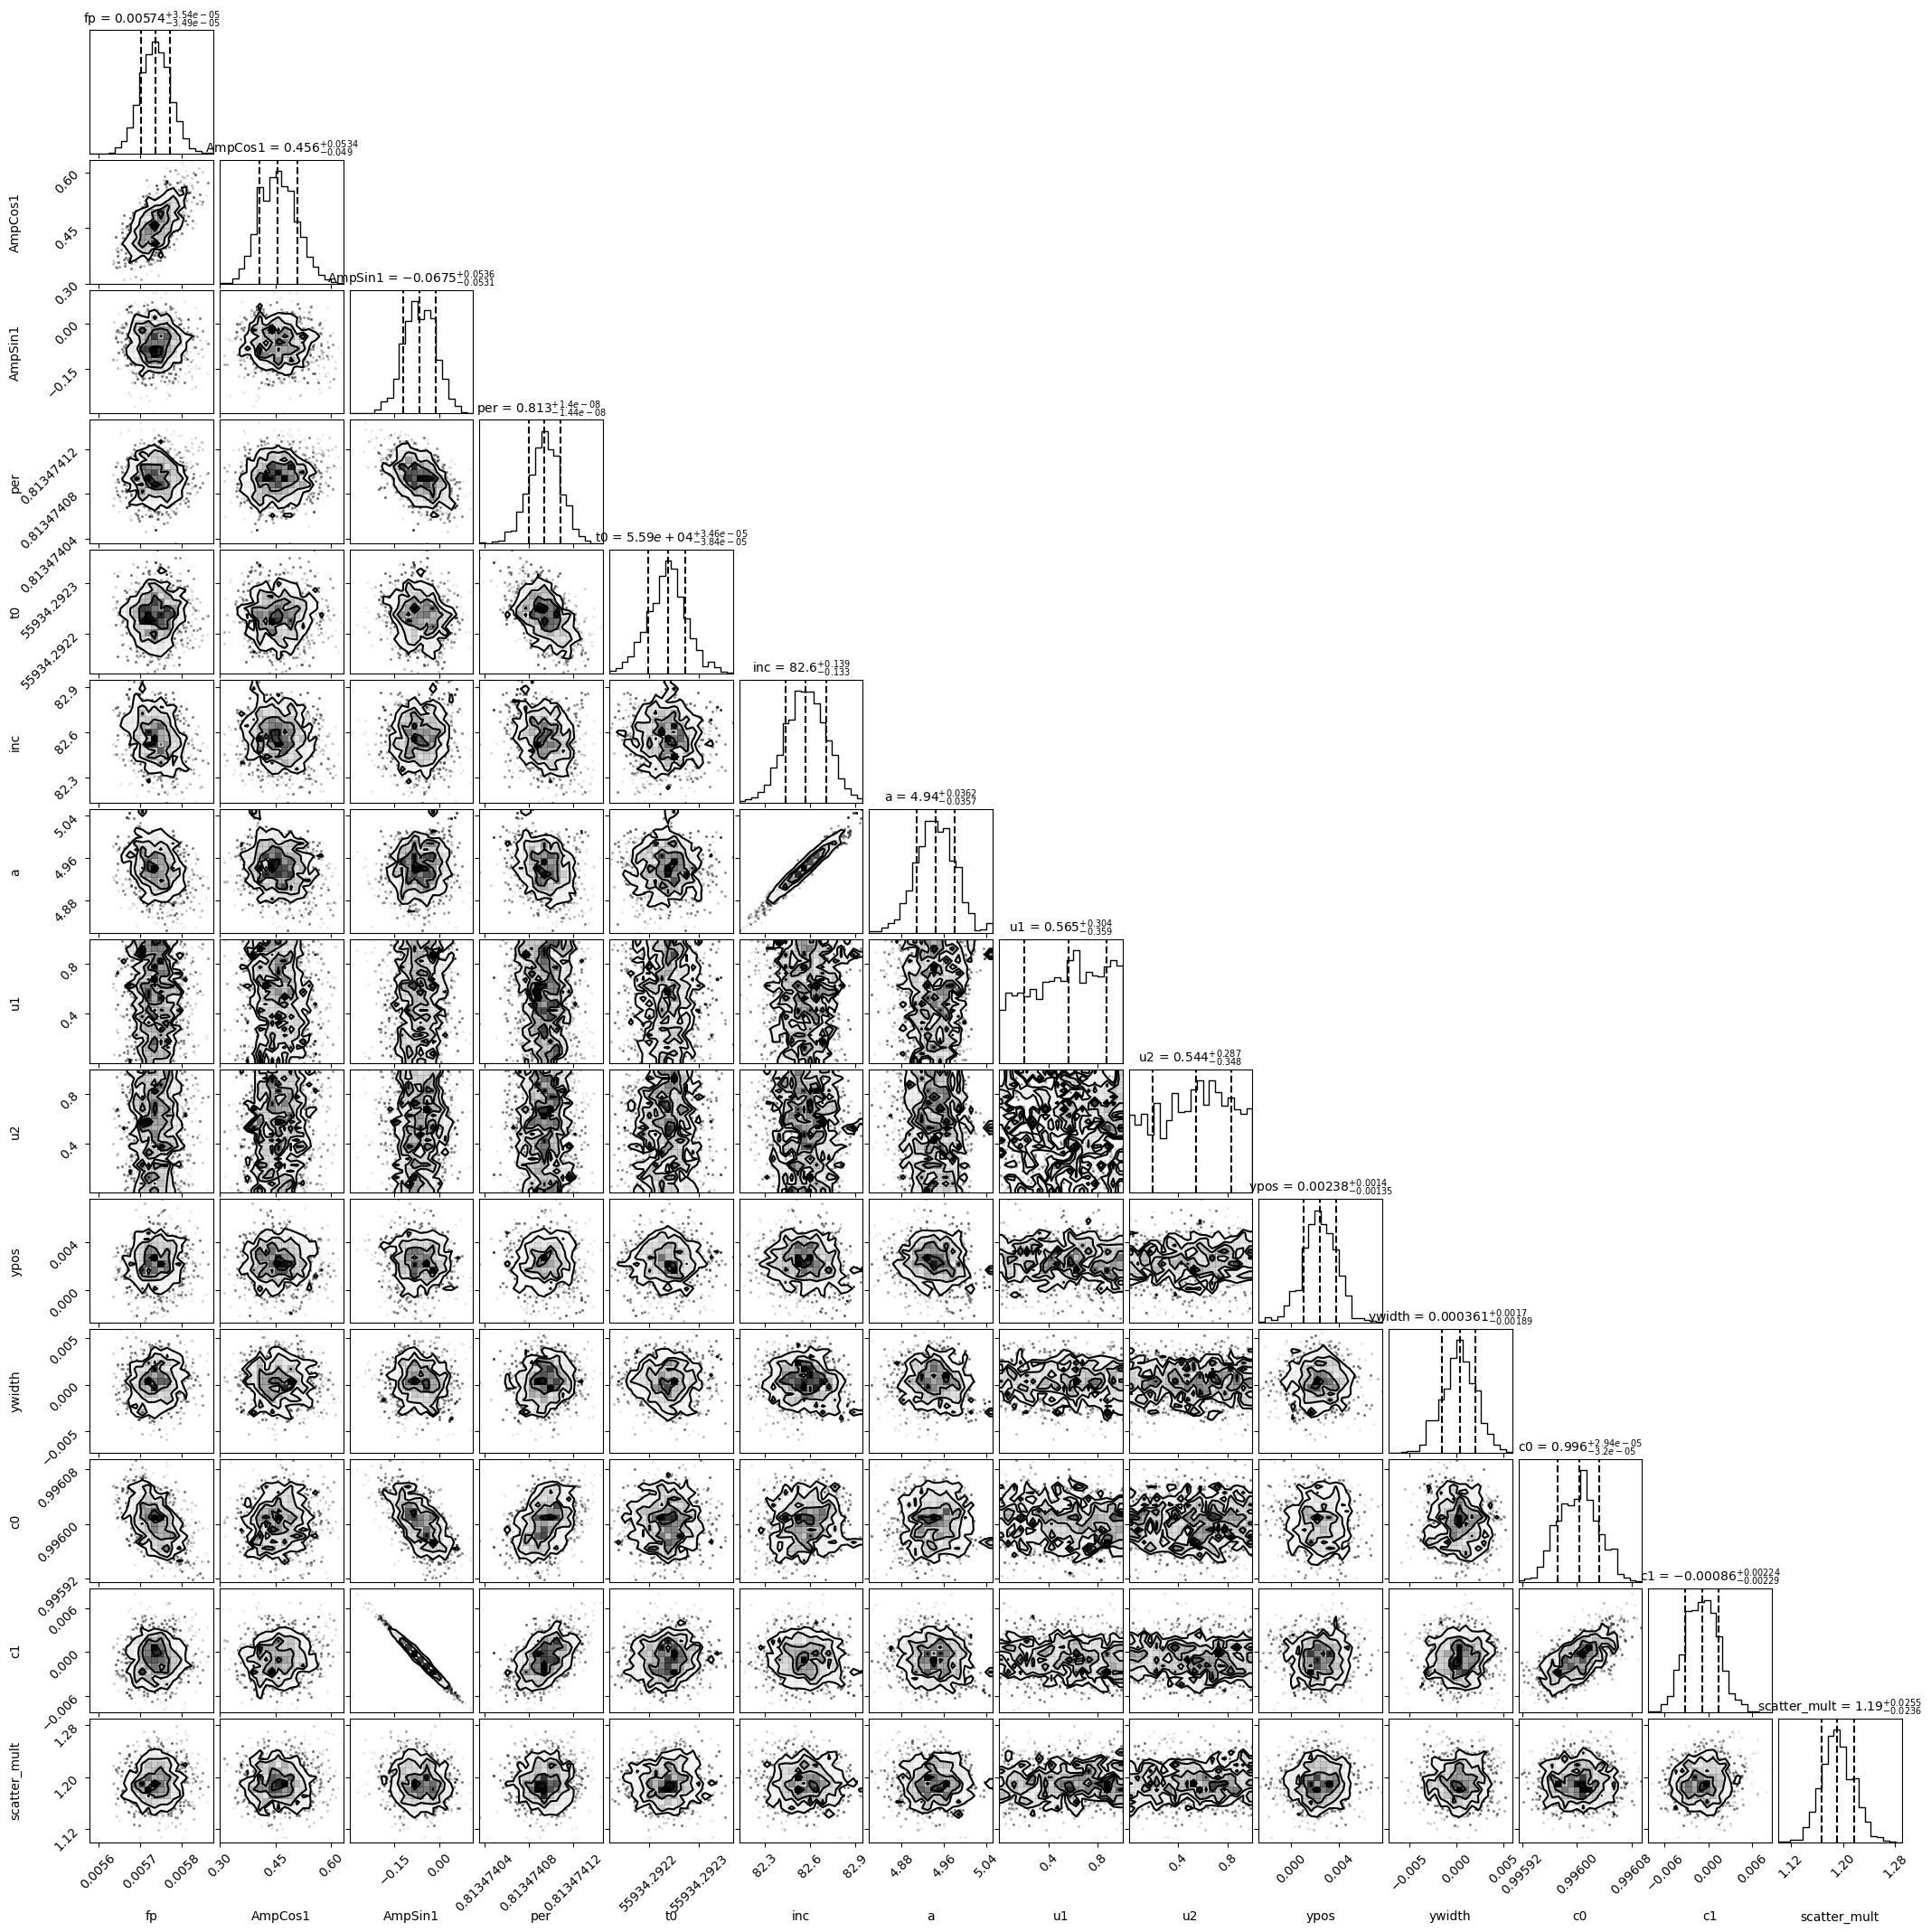

Completed dynesty fit.
-------------------------


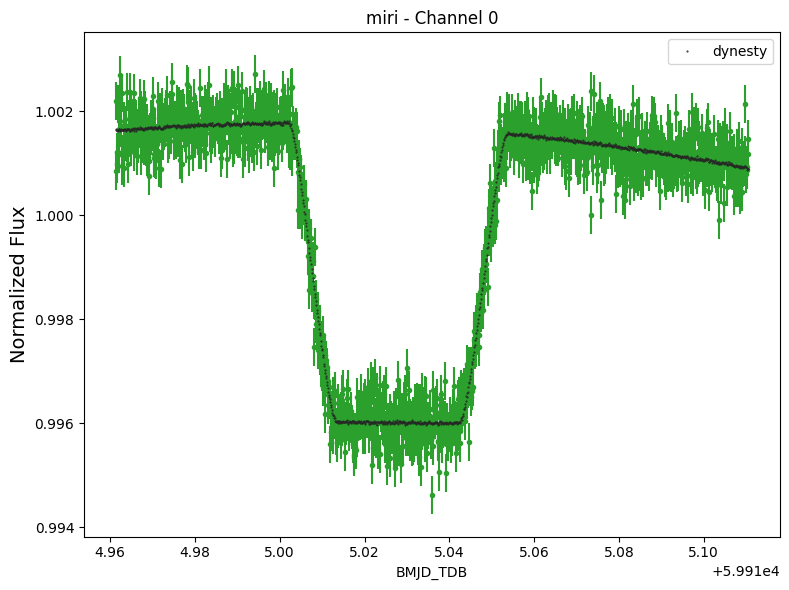

Saving results

Total time (min): 14.6


In [ ]:
s5_meta = eureka.S5_lightcurve_fitting.s5_fit.fitlc(eventlabel)

# Optimizing fits to spectroscopic lightcurves

Now that we know how to find best-fit values and uncertainties from a single "white" lightcurve, it is easy to extrapolate those skills to perform fits to "spectroscopic" lightcurves to evaluate how parameters like the eclipse depth vary as a function of wavelength (which can tell us about molecules in the planets' atmospheres).

## Adjusting the Stage 5 "Eureka! Control File" (ECF)

Thankfully we can reuse the vast majority of our ECF settings above with only a few minor tweaks.

To begin, please first copy below the contents of the ECF that you filled out above. Then:

1. Change `fit_method` back to `[lsq]` to go back to using the optimization algorithm. Running dynesty on each channel will take too long to be completed during this workshop but could be an interesting exercise on your own.
2. Since we're now fitting spectroscopic lightcurves, we'll adjust the `inputdir` to `Stage4/S4_2023-06-02_miri_run1` and the `outputdir` to `Stage5`. This `inputdir` setting will use our provided Stage 4 output files, but if you want to try using your own results from Workshop #1, you can instead set `intputdir` to `Stage4` to use your most recent Stage4 result or you can choose a specific run using the syntax `Stage4/S4_YYYY-MM-DD_miri_runN` where YYYY is the year (e.g., `2023`), MM is the month (e.g., `07`), DD is the day (e.g., `24`), and N is the particular run number that you want to use (e.g., `1`).

And that's it for adjustments to the ECF!

In [ ]:
s5_ecf_contents = f"""
# Eureka! Control File for Stage 5: Lightcurve Fitting

# Stage 5 Documentation: https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5

ncpu            1 # The number of CPU threads to use when running emcee or dynesty in parallel

allapers        False                   # Run S5 on all of the apertures considered in S4? Otherwise will use newest output in the inputdir
rescale_err     False                   # Rescale uncertainties to have reduced chi-squared of unity
fit_par         ./S5_fit_par_template.epf   # What fitting epf do you want to use?
verbose         True                    # If True, more details will be printed about steps
fit_method      [lsq]             #options are: lsq, emcee, dynesty (can list multiple types separated by commas)
run_myfuncs     [batman_ecl, sinusoid_pc, polynomial, ypos, ywidth]   # options are: batman_tr, batman_ecl, sinusoid_pc, expramp, polynomial, step, xpos, ypos, xwidth, ywidth, and GP (can list multiple types separated by commas)

# Manual clipping in time
manual_clip     None    # A list of lists specifying the start and end integration numbers for manual removal.
force_positivity   True
# Limb darkening controls
# IMPORTANT: limb-darkening coefficients are not automatically fixed then, change to 'fixed' in .epf file whether they should be fixed or fitted!
use_generate_ld  None  # use the generated limb-darkening coefficients from Stage 4? Options: exotic-ld, None. For exotic-ld, the limb-darkening laws available are linear, quadratic, 3-parameter and 4-parameter non-linear.
ld_file          None  # Fully qualified path to the location of a limb darkening file that you want to use
ld_file_white    None  # Fully qualified path to the location of a limb darkening file that you want to use for the white-light light curve (required if ld_file is not None and any EPF parameters are set to white_free or white_fixed).

# General fitter
old_fitparams   None # filename relative to topdir that points to a fitparams csv to resume where you left off (set to None to start from scratch)

#lsq
lsq_method      'Powell' # The scipy.optimize.minimize optimization method to use
lsq_tol         1e-6    # The tolerance for the scipy.optimize.minimize optimization method
lsq_maxiter     None    # Maximum number of iterations to perform. Depending on the method each iteration may use several function evaluations. Set to None to use the default value

#mcmc
old_chain       None    # Output folder relative to topdir that contains an old emcee chain to resume where you left off (set to None to start from scratch)
lsq_first       True    # Initialize with an initial lsq call (can help shorten burn-in, but turn off if lsq fails). Only used if old_chain is None
run_nsteps      1000
run_nwalkers    200
run_nburn       500     # How many of run_nsteps should be discarded as burn-in steps

#dynesty
run_nlive       121    # Must be > ndim * (ndim + 1) // 2
run_bound       'multi'
run_sample      'auto'
run_tol         0.1

#GP inputs
kernel_inputs   ['time'] #options: time
kernel_class    ['Matern32'] #options: ExpSquared, Matern32, Exp, RationalQuadratic for george, Matern32 for celerite (sums of kernels possible for george separated by commas)
GP_package      'celerite' #options: george, celerite

# Plotting controls
interp          False   # Should astrophysical model be interpolated (useful for uneven sampling like that from HST)

# Diagnostics
isplots_S5      5       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nbin_plot       None     # The number of bins that should be used for figures 5104 and 5304. Defaults to 100.
testing_S5      False   # Boolean, set True to only use the first spectral channel
testing_model   False   # Boolean, set True to only inject a model source of systematics
hide_plots      False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir          /content/drive/MyDrive/SSW2023/MIRI

# Directories relative to topdir
inputdir        Stage4/S4_2023-07-24_miri_run1   # The folder containing the outputs from Eureka!'s S4 pipeline (will be overwritten if calling S4 and S5 sequentially)
outputdir       Stage5
# Fill this text block with the contents of your S5 ECF from above,
# and then adjust the values as described above

"""

with open(f'S5_{eventlabel}.ecf', 'w') as f:
    f.write(s5_ecf_contents)

## Adjusting the Stage 5 "Eureka! Parameter File" (EPF)

Thankfully we can reuse the vast majority of our EPF settings above with only a few minor tweaks.

To begin, please first copy below the contents of the EPF that you filled out above. Then you just need to set any parameters that cannot vary with wavelength to be `'fixed'`. The relevant parameters that cannot vary with wavelength are the orbital parameters which are `per`, `t0`, `a`, and `inc`.

One option is to fix these parameters to the best-fit values obtained from your optimization run near the top of the notebook. Alternatively, you could also fix them to the published values from Bonomo et al. 2017. If you go with the former, copy-paste your best-fit values for `per`, `t0`, `a`, and `inc` into the `Value` column and set the `Free?` column to `'fixed'`. If you go with the latter option, you just need to set the `Free?` column to `'fixed'`.

In [ ]:
s5_epf_contents = f"""
# Stage 5 Fit Parameters Documentation: https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5-fit-parameters


# Name       Value         Free?          PriorPar1    PriorPar2    PriorType
# "Free?" can be free, fixed, white_free, white_fixed, shared, or independent
# PriorType can be U (Uniform), LU (Log Uniform), or N (Normal).
# If U/LU, PriorPar1 and PriorPar2 represent upper and lower limits of the parameter/log(the parameter).
# If N, PriorPar1 is the mean and PriorPar2 is the standard deviation of a Gaussian prior.
#-------------------------------------------------------------------------------------------------------
#
# ------------------
# ** Transit/eclipse parameters **
# ------------------
Rs 0.667 'fixed'
rp 0.15738 'fixed'
time_offset 0 'independent'

fp 6000e-6 'free' 6000e-6 5000e-6 N

# ----------------------
# ** Phase curve parameters **
# ----------------------
AmpCos1 0 'free' -1 1 U
AmpSin1 0 'free' -1 1 U

#AmpCos2      0.01          'free'         -1           1            U
#AmpSin2      0.01          'free'         -1           1            U
# ------------------
# ** Orbital parameters **
# ------------------
per 0.8134740941512996 'fixed' 0.81347437 0.00000013 N
t0 55934.29223745282 'fixed' 55934.292239 0.000040 N
inc 82.56991497629944 'fixed' 82.33 0.20 N
a 4.944354835507415 'fixed' 4.93 0.10 N
ecc 0 'fixed'
w 90 'fixed'

# -------------------------
# ** Limb darkening parameters **
# Choose limb_dark from ['uniform', 'linear', 'quadratic', 'kipping2013', 'squareroot', 'logarithmic', 'exponential','3-parameter', '4-parameter']
# When using generated limb-darkening coefficients from exotic-ld choose from ['linear', 'quadratic', '3-parameter', '4-parameter']
# -------------------------
limb_dark    'kipping2013'  'independent'
u1           0.59           'free'         0            1            U
u2           0.84           'free'         0            1            U
# --------------------
# ** Systematic variables **
# Polynomial model variables (c0--c9 for 0th--3rd order polynomials in time); Fitting at least c0 is very strongly recommended!
# Exponential ramp model variables (r0--r2 for one exponential ramp, r3--r5 for a second exponential ramp)
# GP model parameters (A, WN, m1, m2) in log scale
# Step-function model variables (step# and steptime# for step-function model #; e.g. step0 and steptime0)
# Drift model variables (xpos, ypos, xwidth, ywidth)
ypos 0 'free' 0 0.1 N
ywidth 0 'free' 0 10 N

# --------------------
c0 1 'free' 1 0.001 N
c1 0 'free' 0 0.01 N

#A            -5             'free'         -20.         -5.          U
#WN           -15            'free'         -20.         -10.         U
#m1           -5             'free'         -10.         0.           U
# -----------
# ** White noise **
# Use scatter_mult to fit a multiplier to the expected noise level from Stage 3 (recommended)
# Use scatter_ppm to fit the noise level in ppm
# Use WN parameter in GP model parameters to account for white noise in the GP model
# -----------
scatter_mult 1.1 'free' 1.1 2 N
# Fill this text block with the contents of your S5 EPF from above,
# and then adjust the values as described above

"""

with open('S5_fit_par_template.epf', 'w') as f:
    f.write(s5_epf_contents)

## Running Eureka!'s Stage 5

The following cell will run Eureka!'s Stage 5 using the settings you defined above. Note that your ECF and EPF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The code will loop through each wavelength channel, printing information about the fit and showing plots as it goes.

The following fits should take a total of ~4 minutes to complete on Google Colab. While waiting for the fits to complete, you could begin setting up the next section.

Finished loading parameters from /content/drive/MyDrive/SSW2023/MIRI/Stage4/S4_2023-07-24_miri_run1/ap6_bg12//S4_miri_ap6_bg12_LCData.h5

Starting Stage 5: Light Curve Fitting

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage4/S4_2023-07-24_miri_run1/ap6_bg12/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage5/S5_2023-07-26_miri_run1/ap6_bg12/
Copying S5 control file
Copying S5 parameter control file

Starting Channel 1 of 11

Starting lsq fit.
Starting lnprob: -11719.709301209448


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Current lnprob =  7110.769511169647
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -7110.769511169647
       x: [ 4.643e-03  6.313e-02 -4.024e-02  5.900e-01  8.400e-01
            8.609e-03  1.446e-04  9.967e-01 -3.671e-03  1.108e+00]
     nit: 11
   direc: [[ 1.717e-03 -3.603e-01 ...  4.886e-03 -8.449e-01]
           [ 8.096e-05  1.939e-02 ... -4.571e-03  1.844e-02]
           ...
           [ 2.161e-04  5.763e-01 ... -1.302e-03 -3.008e-02]
           [-4.472e-05 -4.023e-02 ... -3.959e-03 -1.330e-02]]
    nfev: 2196

Ending lnprob: 7110.769511169647
Reduced Chi-squared: 1.0073041707469388

LSQ RESULTS:
fp: 0.004642816822724149
AmpCos1: 0.06312988204613496
AmpSin1: -0.04024012954236118
u1: 0.5900000009199468
u2: 0.8399999990800532
ypos: 0.008609361337248671
ywidth: 0.00014455634501437487
c0: 0.9966540228349903
c1: -0.0036709585994761196
scatter_mult: 1.108398250026284; 811.2073852609662 ppm



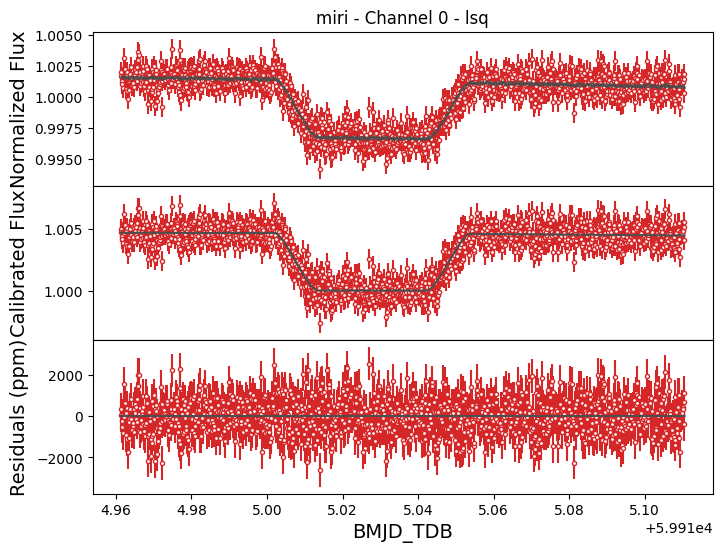

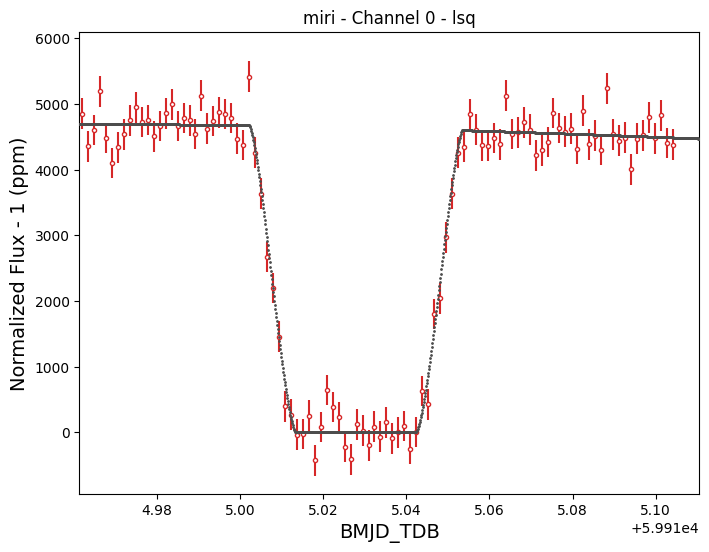

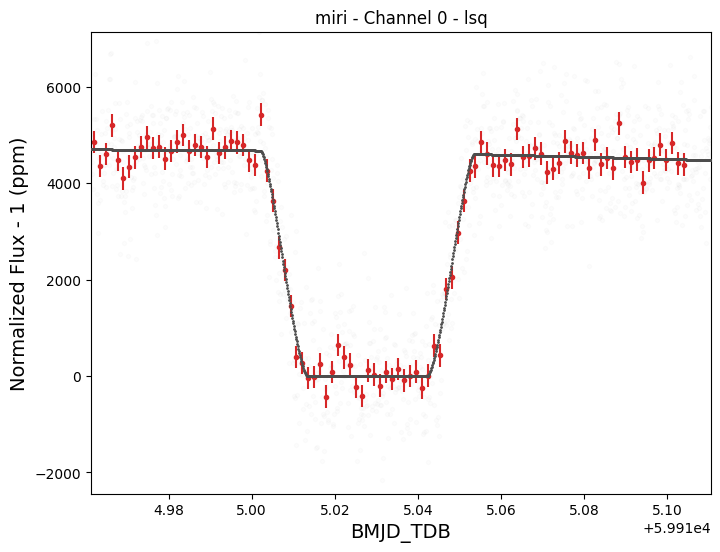

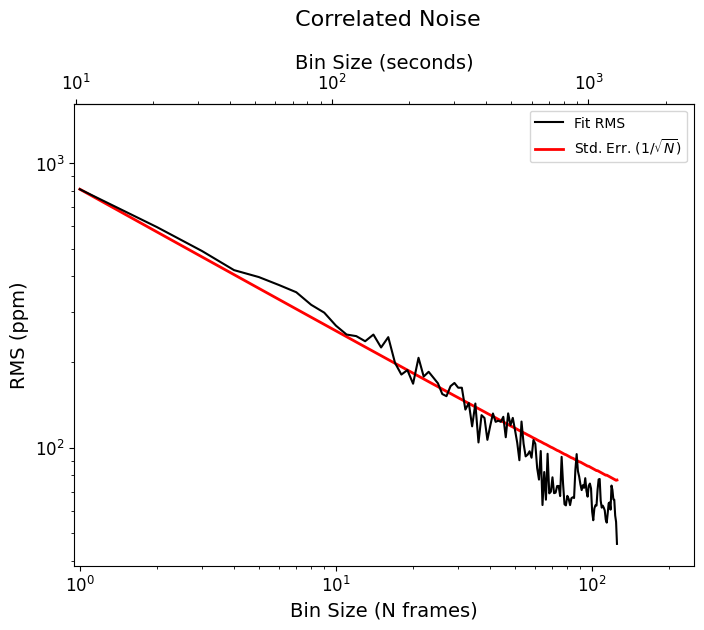

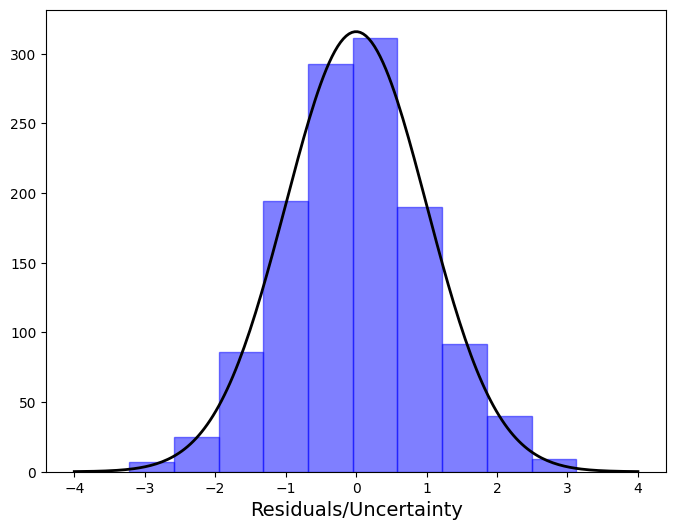

Completed lsq fit.
-------------------------


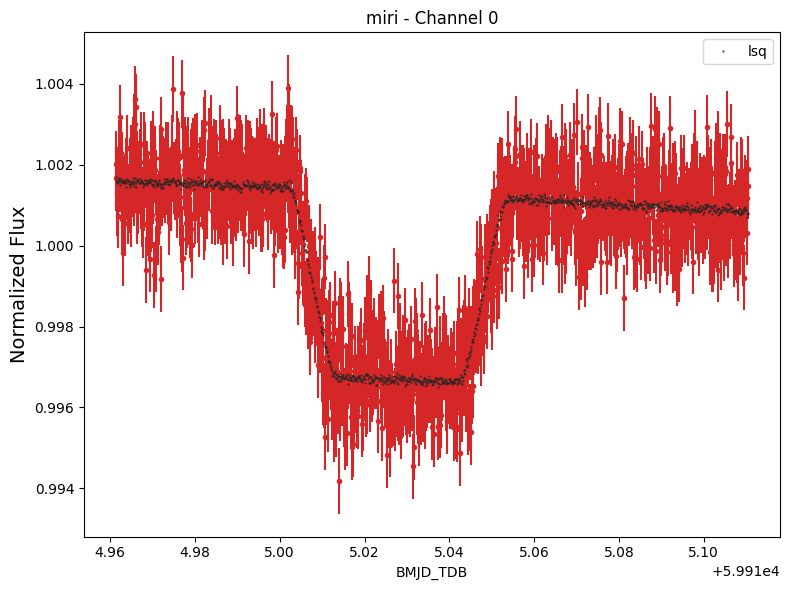

Saving results

Starting Channel 2 of 11

Starting lsq fit.
Starting lnprob: 6969.13297654206
Current lnprob =  6996.723733475974
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6996.723733475974
       x: [ 5.094e-03  2.235e-01  2.863e-02  5.900e-01  8.400e-01
            2.894e-03 -9.950e-03  9.964e-01 -5.970e-03  1.128e+00]
     nit: 7
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [-1.119e-05 -4.314e-02 ... -8.493e-04  8.847e-04]
           ...
           [ 2.778e-04  1.168e-01 ...  5.054e-04 -1.599e-02]
           [ 1.019e-05  3.355e-02 ... -1.883e-03 -7.286e-04]]
    nfev: 1407

Ending lnprob: 6996.723733475974
Reduced Chi-squared: 1.0080998209548828

LSQ RESULTS:
fp: 0.005093797032540694
AmpCos1: 0.22345533333099413
AmpSin1: 0.028632399458531053
u1: 0.5900000018253108
u2: 0.8399999981746892
ypos: 0.0028935468510546116
ywidth: -0.009949672954886971
c0: 0.996353858091
c1: -0.005970469999350799
scat

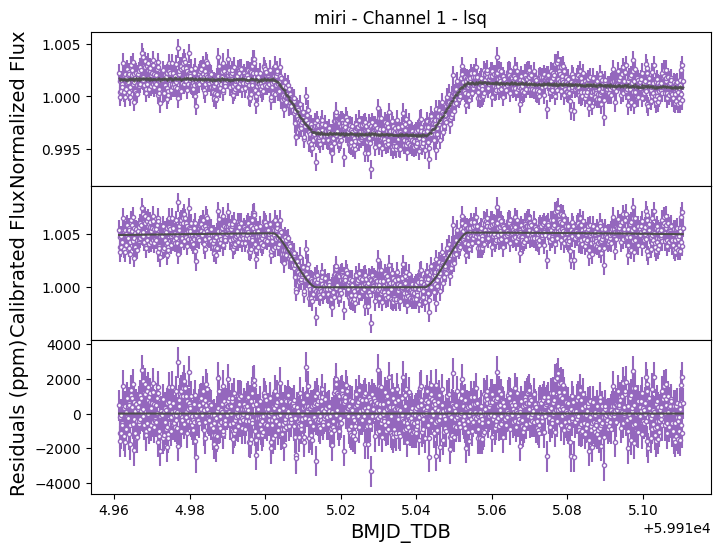

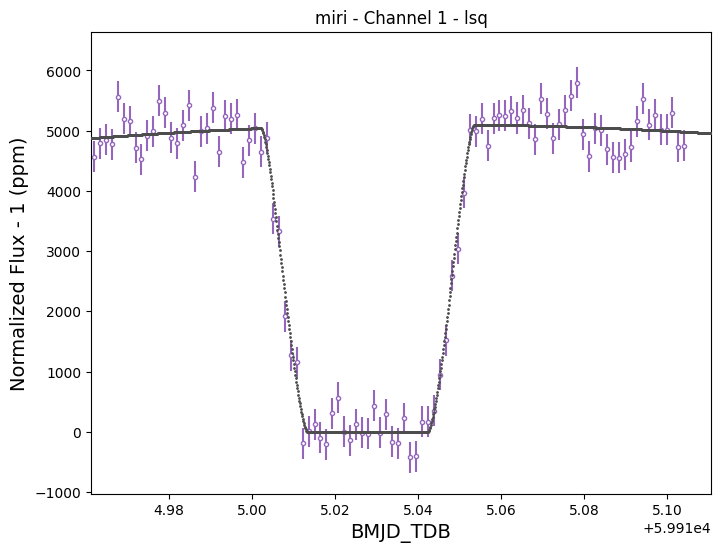

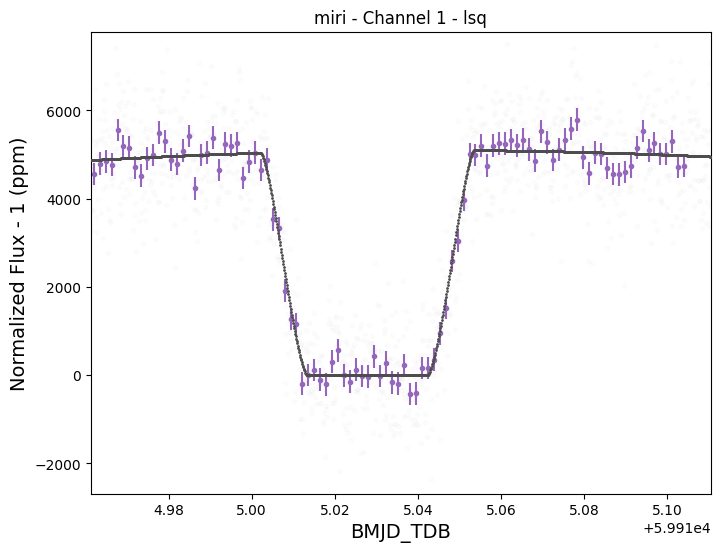

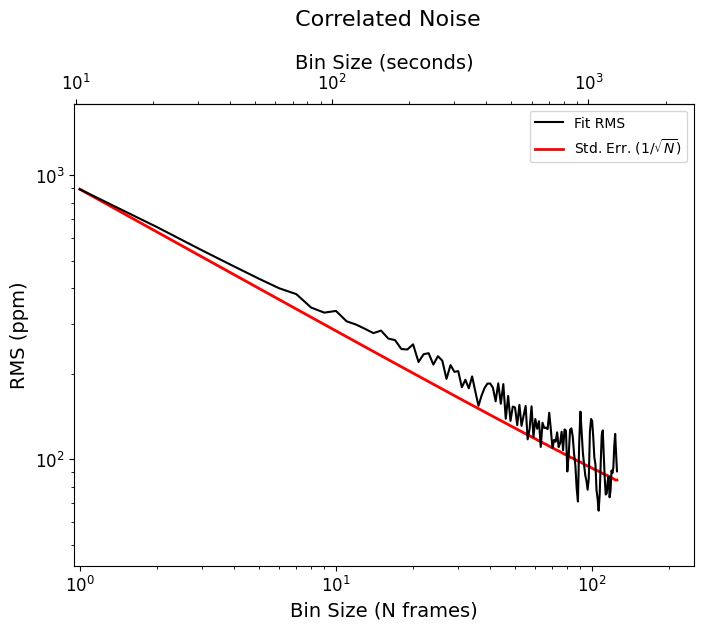

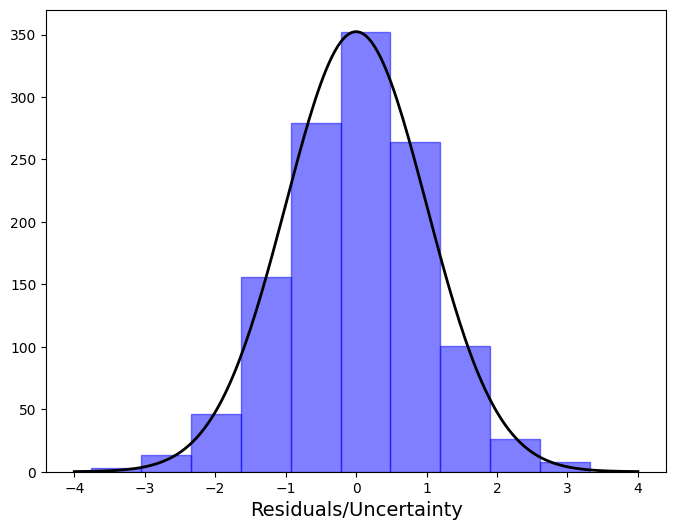

Completed lsq fit.
-------------------------


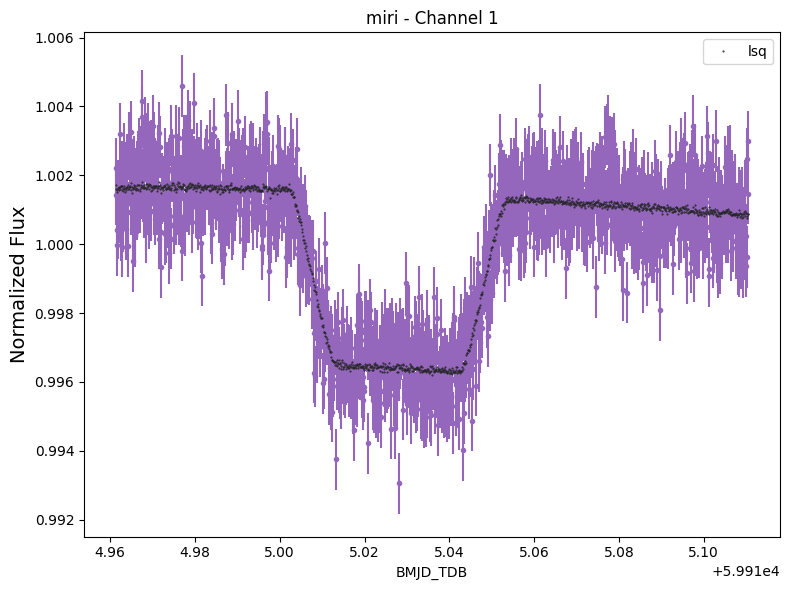

Saving results

Starting Channel 3 of 11

Starting lsq fit.
Starting lnprob: 6947.9350734773225
Current lnprob =  6974.0077831984545
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6974.0077831984545
       x: [ 5.549e-03  6.889e-01  6.639e-02  5.900e-01  8.400e-01
            4.847e-03  7.760e-04  9.962e-01 -5.216e-03  1.169e+00]
     nit: 5
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 1.901e-04  3.507e-01 ...  1.666e-04 -9.375e-03]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 7.663e-05 -4.104e-02 ...  2.653e-04 -3.049e-03]]
    nfev: 968

Ending lnprob: 6974.0077831984545
Reduced Chi-squared: 1.0074646435585828

LSQ RESULTS:
fp: 0.005549136733318152
AmpCos1: 0.688876503924764
AmpSin1: 0.06639244094917247
u1: 0.590000001994099
u2: 0.839999998005901
ypos: 0.004846714939563684
ywidth: 0.000775950821386697
c0: 0.9961597348859351
c1: -0.005215777386018019
sca

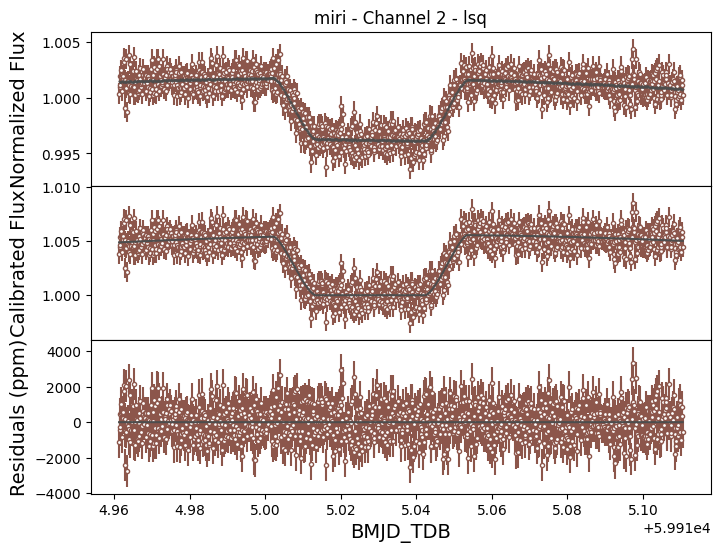

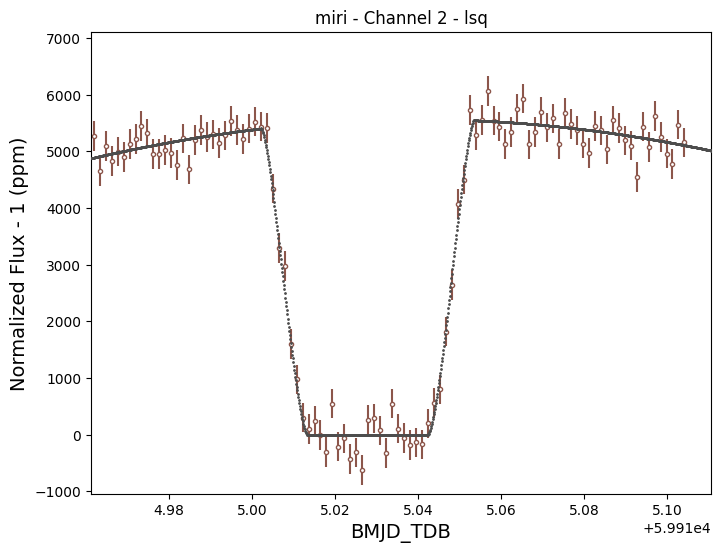

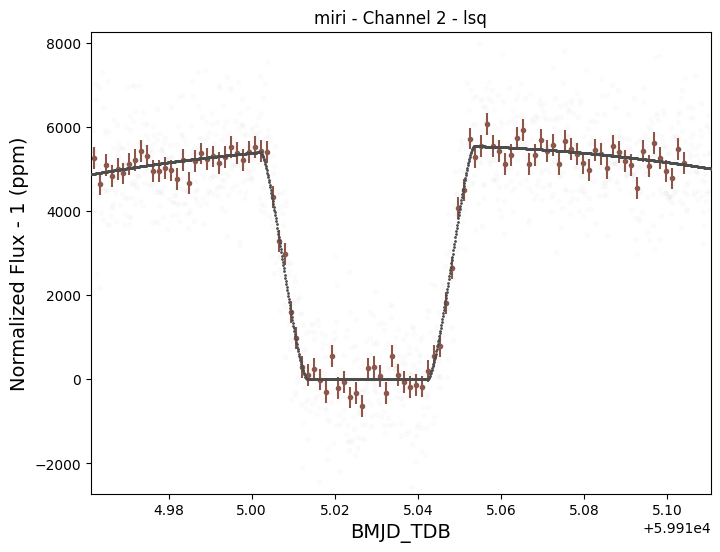

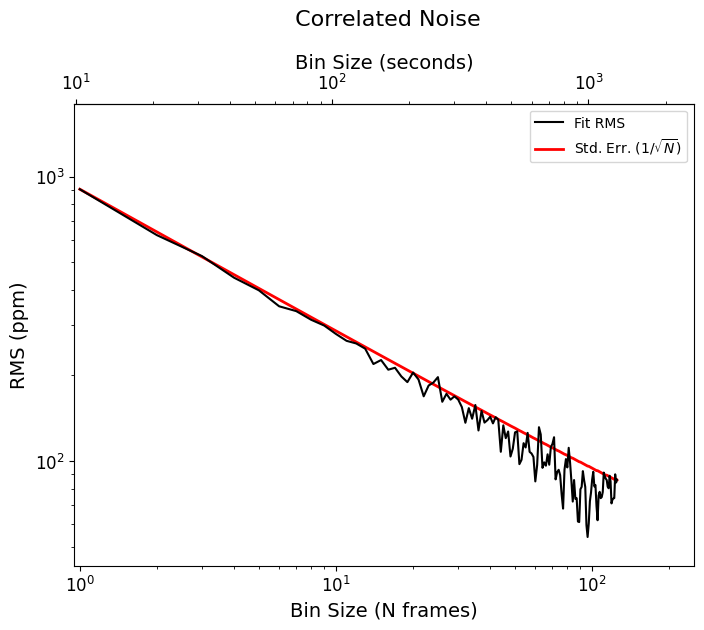

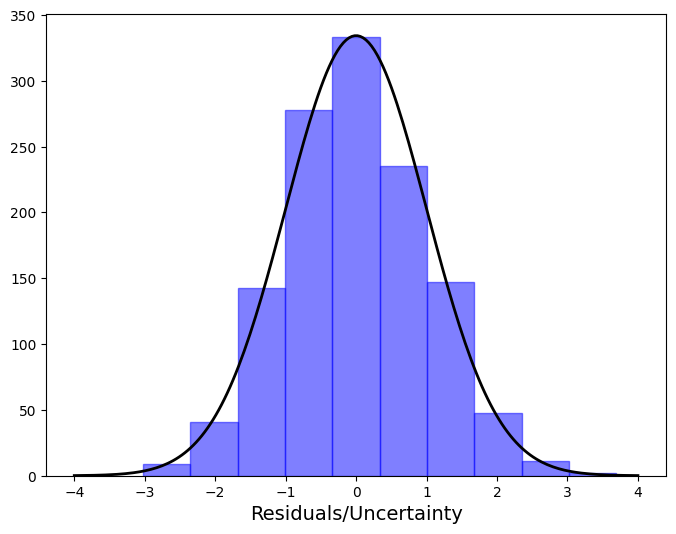

Completed lsq fit.
-------------------------


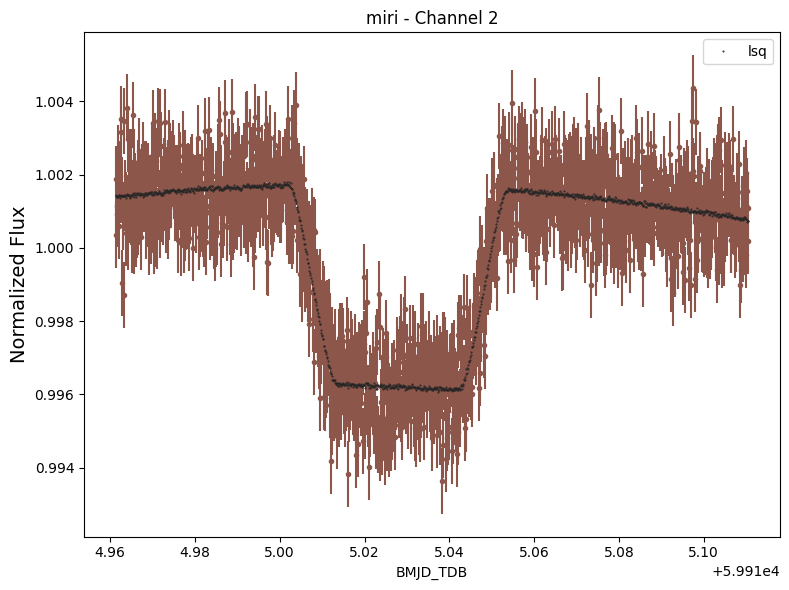

Saving results

Starting Channel 4 of 11

Starting lsq fit.
Starting lnprob: 6810.673190188855
Current lnprob =  6823.617429479018
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6823.617429479018
       x: [ 5.144e-03  5.067e-01  3.580e-02  5.900e-01  8.400e-01
            5.423e-03 -1.226e-03  9.964e-01 -5.124e-03  1.176e+00]
     nit: 7
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [-3.238e-05 -2.771e-02 ...  2.337e-04 -1.894e-03]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-3.554e-06 -1.447e-02 ... -3.057e-05 -4.618e-04]]
    nfev: 1365

Ending lnprob: 6823.617429479018
Reduced Chi-squared: 1.0068541188216054

LSQ RESULTS:
fp: 0.005143725277764363
AmpCos1: 0.5067151117316715
AmpSin1: 0.035801863268924025
u1: 0.5900000021819368
u2: 0.8399999978180631
ypos: 0.005422638875687129
ywidth: -0.001225756107835775
c0: 0.9963984542154338
c1: -0.005124139624986072
s

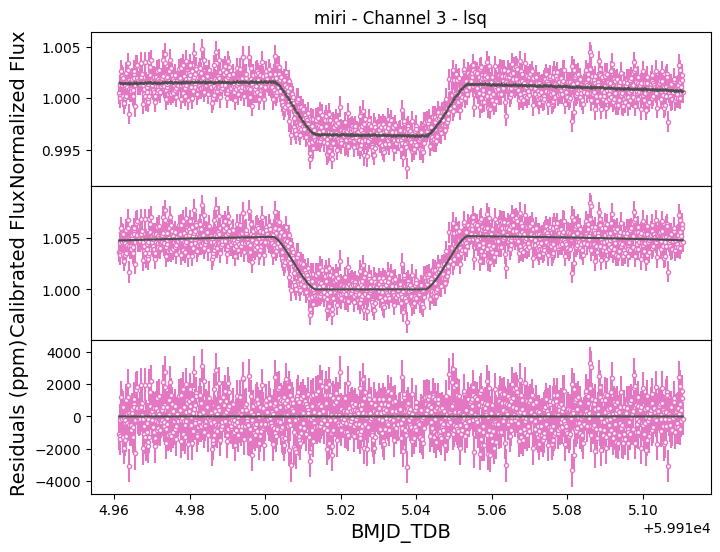

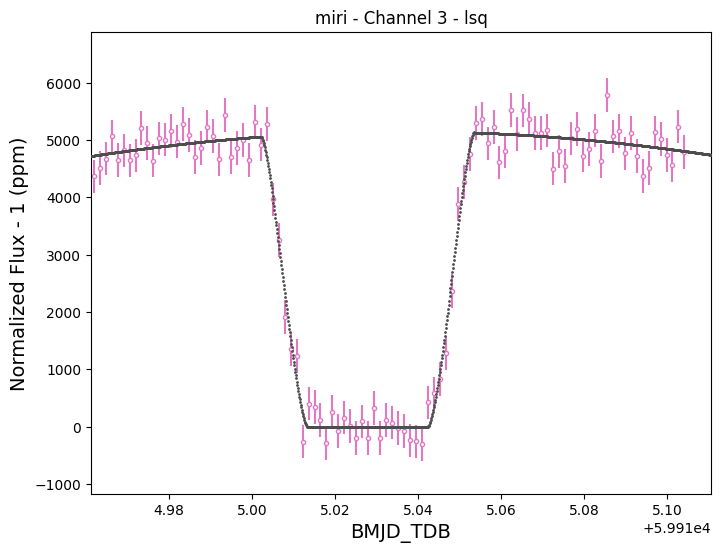

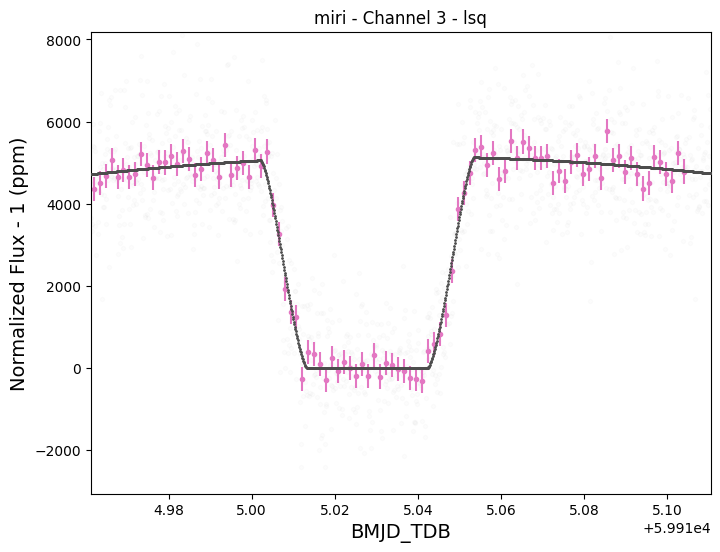

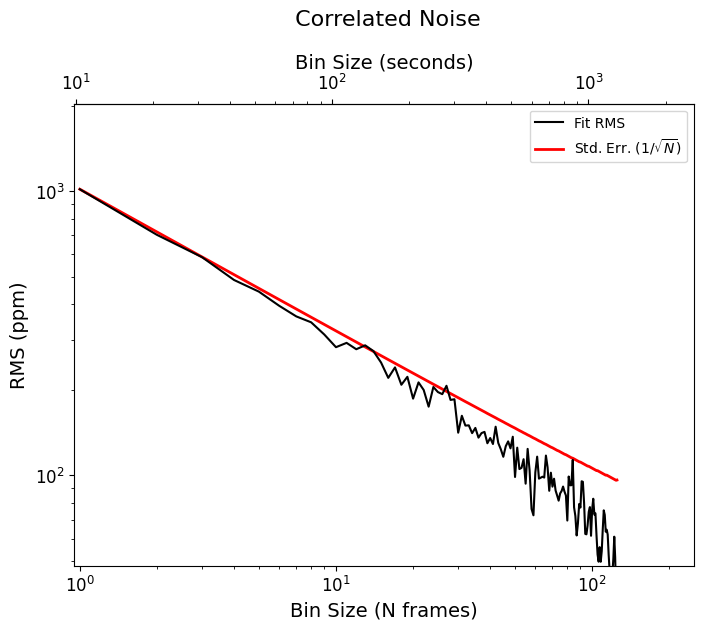

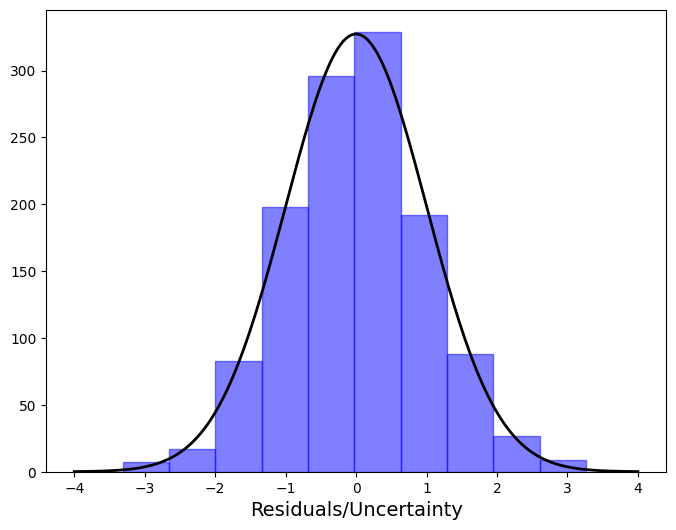

Completed lsq fit.
-------------------------


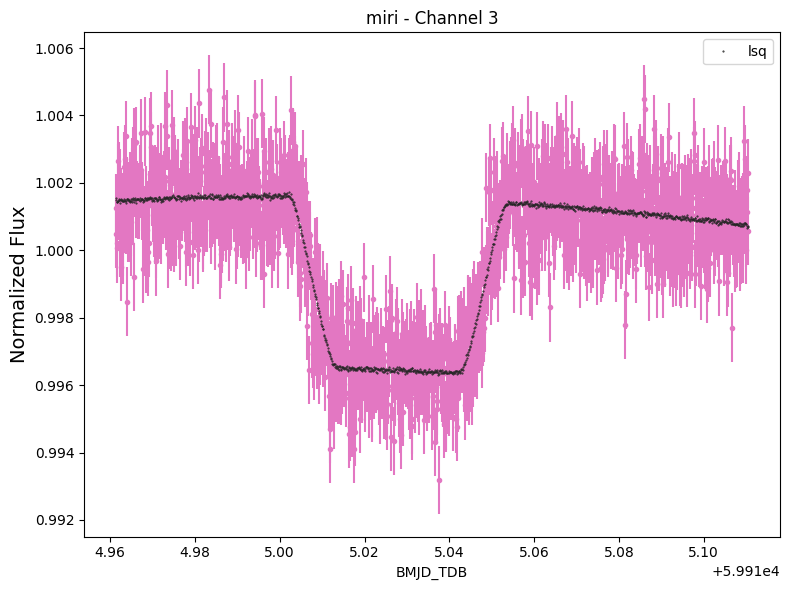

Saving results

Starting Channel 5 of 11

Starting lsq fit.
Starting lnprob: 6725.5642426046
Current lnprob =  6748.314553291074
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6748.314553291074
       x: [ 5.692e-03  6.398e-01 -2.129e-01  5.900e-01  8.400e-01
            3.314e-03 -1.332e-03  9.961e-01  5.189e-03  1.158e+00]
     nit: 10
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 2.465e-05  7.689e-02 ...  2.030e-03  2.036e-03]
           ...
           [ 2.543e-05  4.187e-03 ...  2.209e-04 -1.543e-03]
           [-8.066e-06 -2.214e-02 ...  3.950e-04 -1.273e-04]]
    nfev: 1946

Ending lnprob: 6748.314553291074
Reduced Chi-squared: 1.0073323237571818

LSQ RESULTS:
fp: 0.005692457040672413
AmpCos1: 0.6398374965754968
AmpSin1: -0.2128539935772311
u1: 0.5900000031238669
u2: 0.839999996876133
ypos: 0.0033137245609365104
ywidth: -0.001331536419945062
c0: 0.9961404813399632
c1: 0.005189385405752471
scat

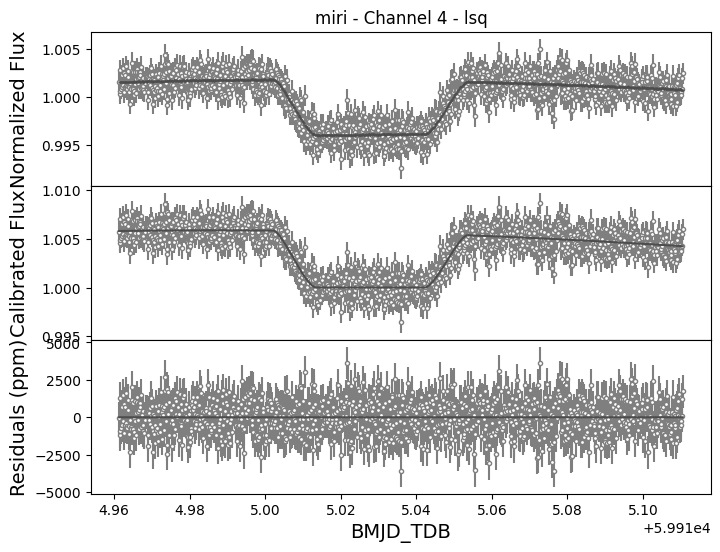

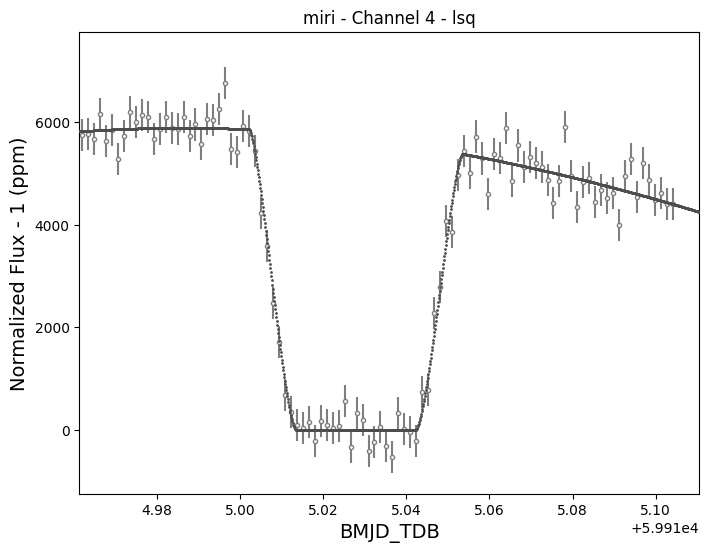

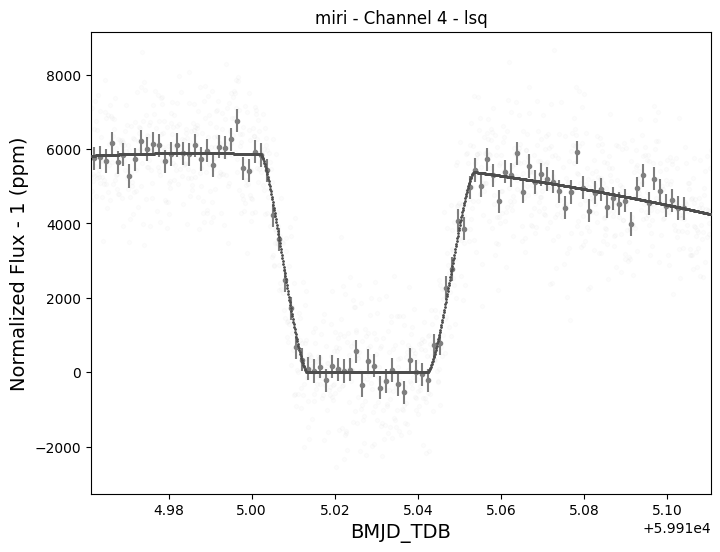

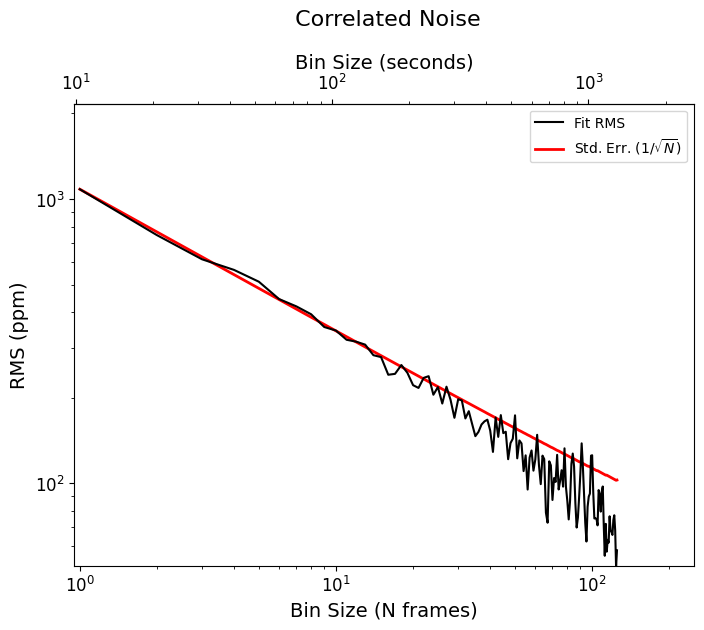

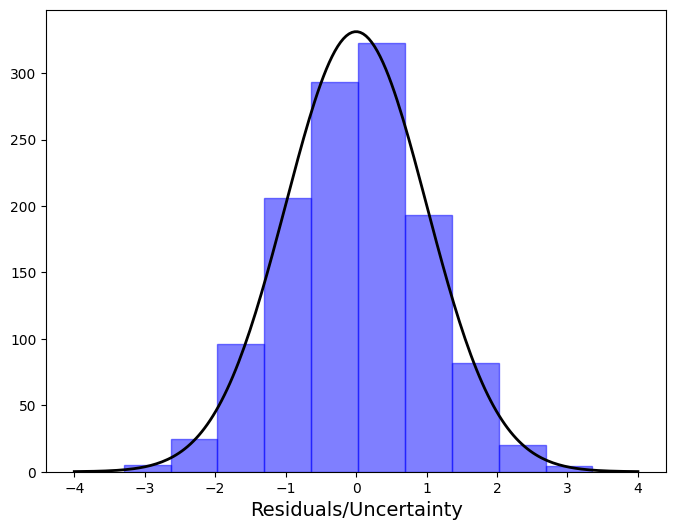

Completed lsq fit.
-------------------------


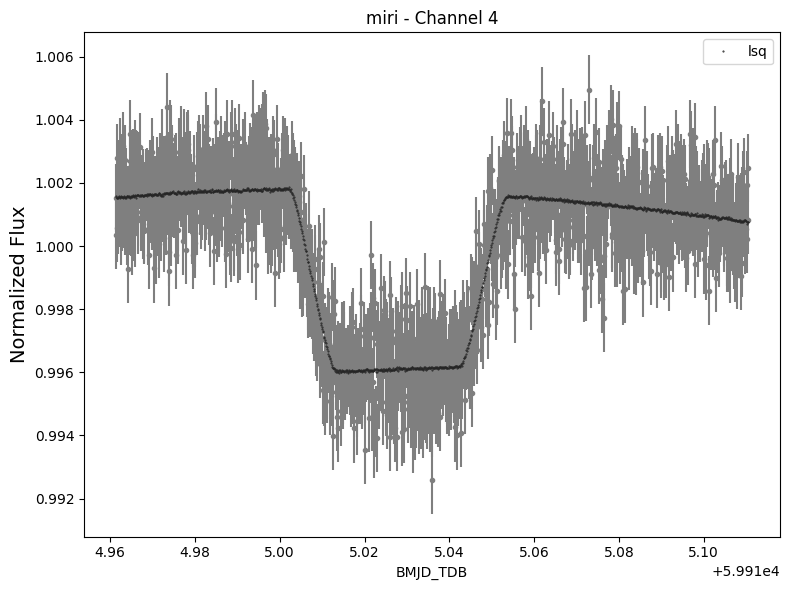

Saving results

Starting Channel 6 of 11

Starting lsq fit.
Starting lnprob: 6583.972795740619
Current lnprob =  6614.689261582594
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6614.689261582594
       x: [ 6.047e-03  2.055e-01 -2.426e-01  5.900e-01  8.400e-01
           -6.010e-03 -1.776e-03  9.958e-01  7.336e-03  1.154e+00]
     nit: 5
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 2.997e-05 -6.986e-02 ...  3.867e-04 -3.926e-03]]
    nfev: 968

Ending lnprob: 6614.689261582594
Reduced Chi-squared: 1.0072707853292235

LSQ RESULTS:
fp: 0.006047382898102833
AmpCos1: 0.20550262804645586
AmpSin1: -0.24262760581260953
u1: 0.5900000032218408
u2: 0.8399999967781592
ypos: -0.0060103105720490015
ywidth: -0.0017759692089929656
c0: 0.9957690243257425
c1: 0.00733632653744652


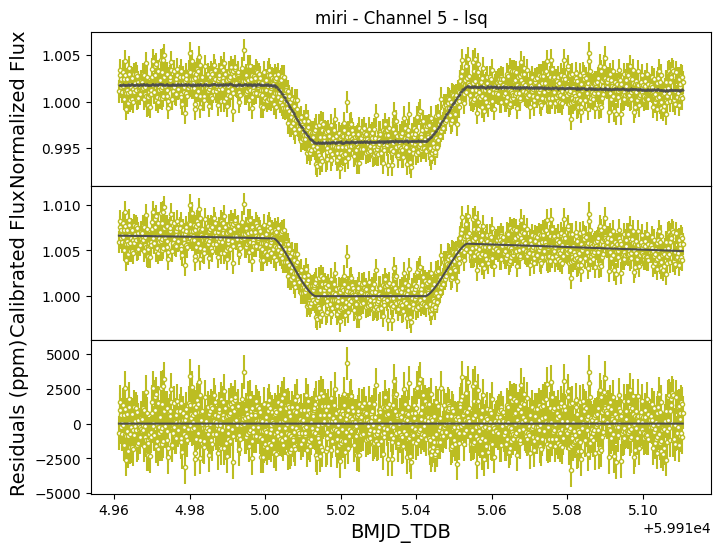

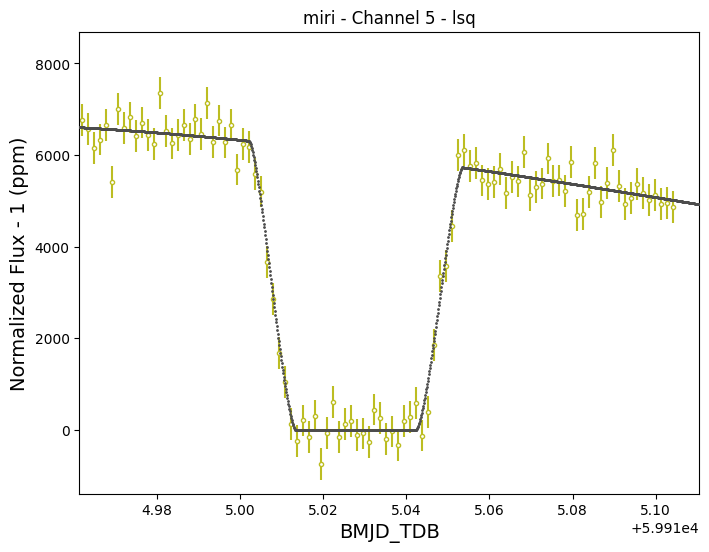

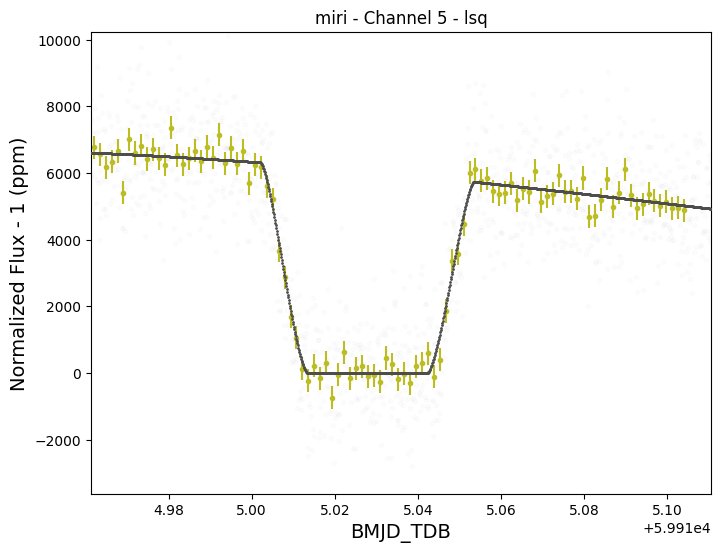

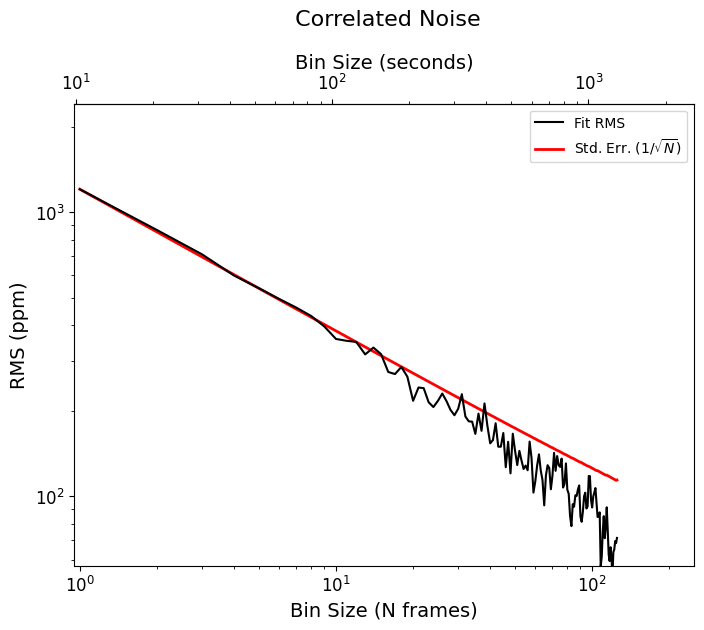

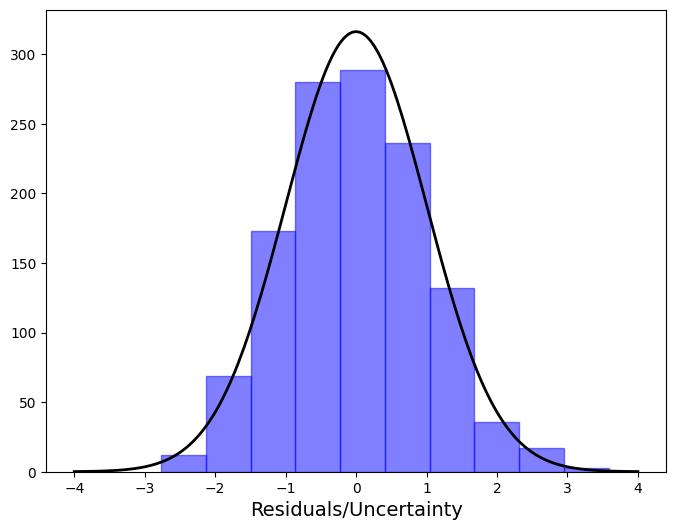

Completed lsq fit.
-------------------------


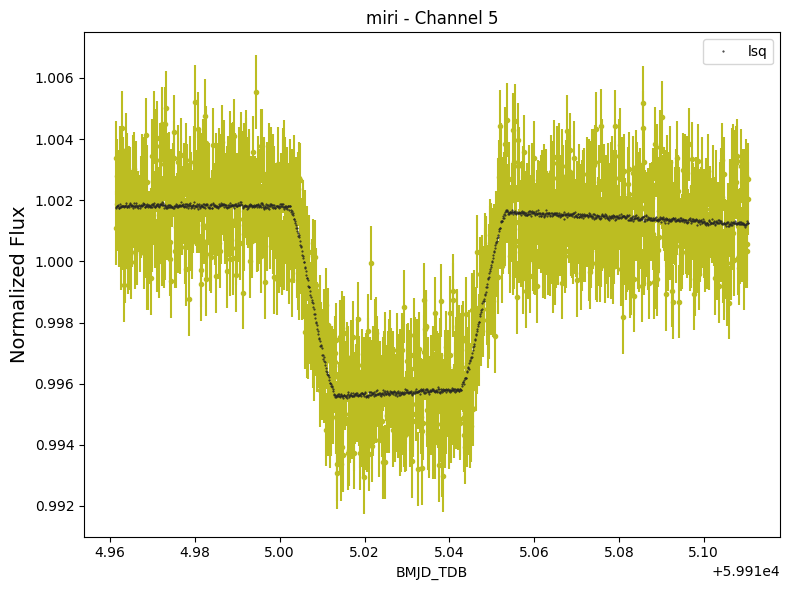

Saving results

Starting Channel 7 of 11

Starting lsq fit.
Starting lnprob: 6520.302190223766
Current lnprob =  6526.009429279456
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6526.009429279456
       x: [ 6.298e-03  5.354e-01 -3.475e-01  5.900e-01  8.400e-01
           -5.782e-03  1.107e-03  9.957e-01  1.448e-02  1.114e+00]
     nit: 8
   direc: [[ 4.892e-05  1.528e-01 ...  2.651e-04 -1.074e-03]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-6.704e-06  1.430e-02 ...  4.984e-03 -6.827e-04]]
    nfev: 1631

Ending lnprob: 6526.009429279456
Reduced Chi-squared: 1.0072648031397387

LSQ RESULTS:
fp: 0.0062979570650072165
AmpCos1: 0.5354484402192347
AmpSin1: -0.34746870197342083
u1: 0.5900000039306101
u2: 0.8399999960693898
ypos: -0.005782243397368844
ywidth: 0.0011070328145184932
c0: 0.9957473606169811
c1: 0.014484168841904455


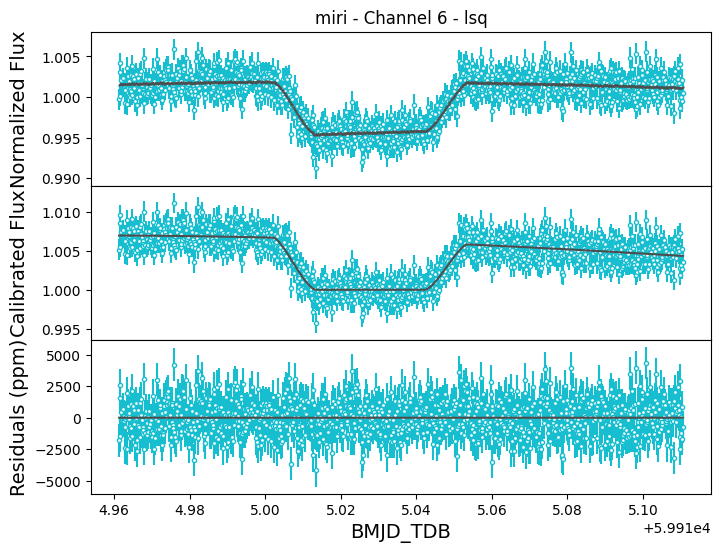

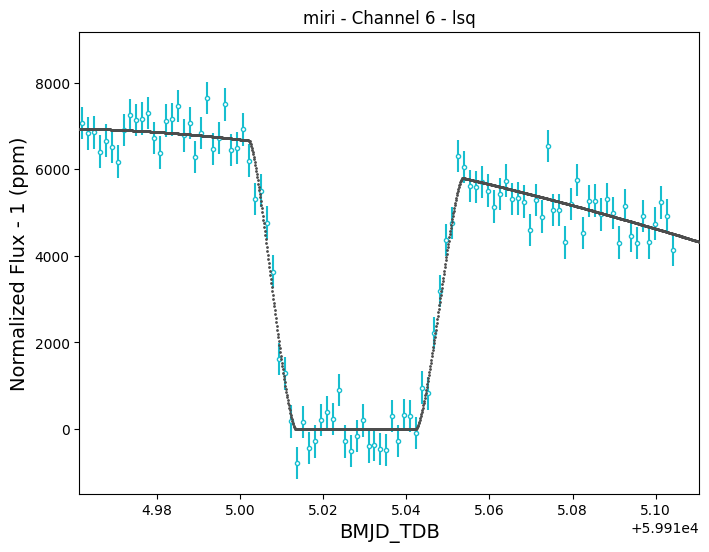

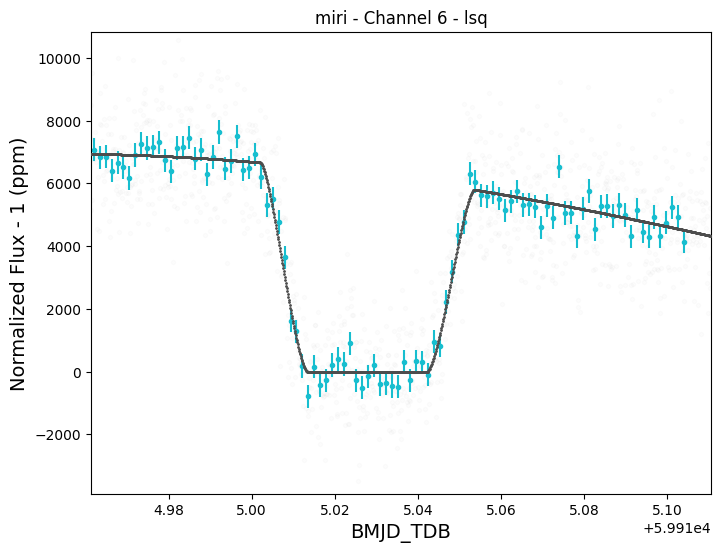

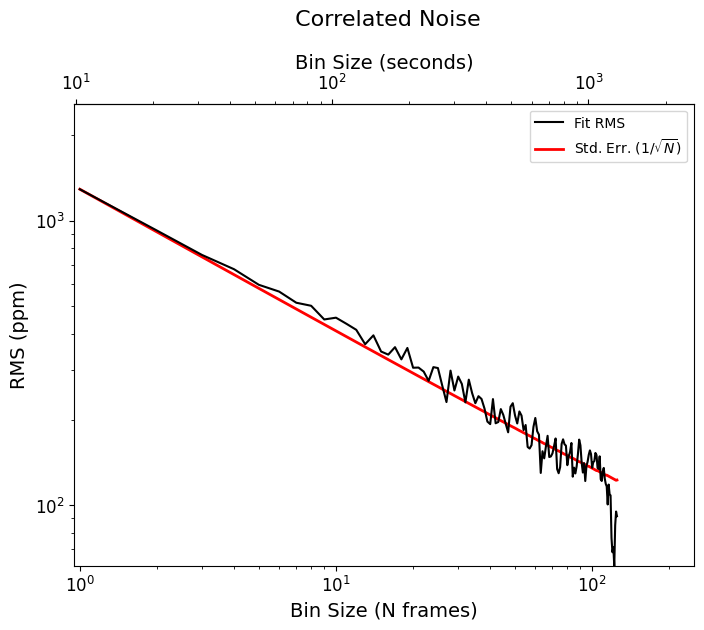

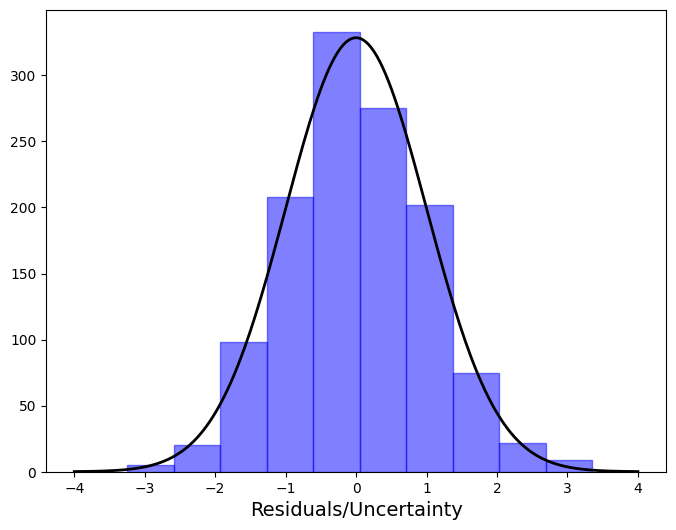

Completed lsq fit.
-------------------------


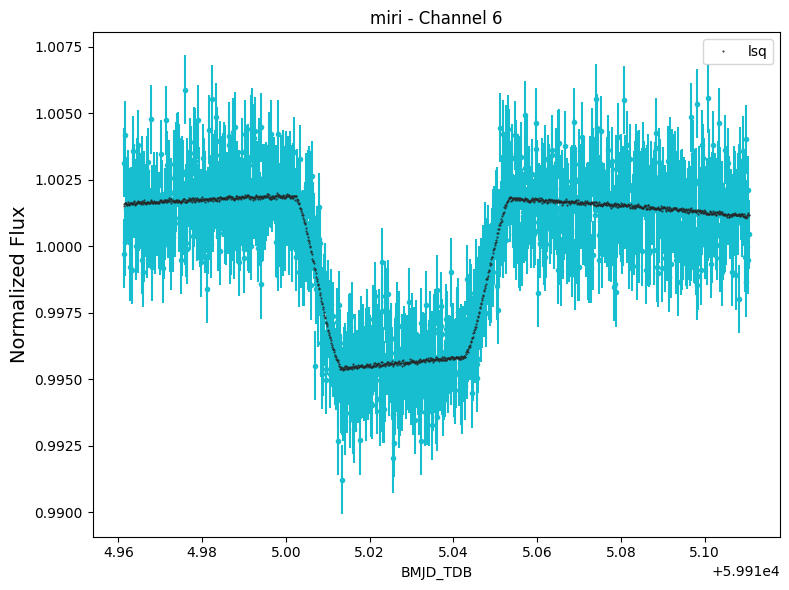

Saving results

Starting Channel 8 of 11

Starting lsq fit.
Starting lnprob: 6362.525528117391
Current lnprob =  6378.988598830841
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6378.988598830841
       x: [ 6.582e-03  5.793e-01 -1.043e-01  5.900e-01  8.400e-01
            3.282e-03  5.686e-03  9.955e-01 -7.864e-04  1.106e+00]
     nit: 9
   direc: [[ 4.823e-05  7.228e-02 ... -9.970e-04 -3.278e-04]
           [-9.070e-05 -1.329e-01 ... -1.125e-02 -3.537e-03]
           ...
           [ 1.396e-04 -7.226e-02 ... -3.312e-04 -3.658e-03]
           [ 1.769e-06  3.237e-03 ... -9.890e-05 -1.016e-04]]
    nfev: 1835

Ending lnprob: 6378.988598830841
Reduced Chi-squared: 1.007267953308991

LSQ RESULTS:
fp: 0.006582385697552798
AmpCos1: 0.5793406254381652
AmpSin1: -0.10429908040429221
u1: 0.5900000046128111
u2: 0.8399999953871888
ypos: 0.003282326315938052
ywidth: 0.005686171123493804
c0: 0.9954776004817674
c1: -0.0007863707651919403
sc

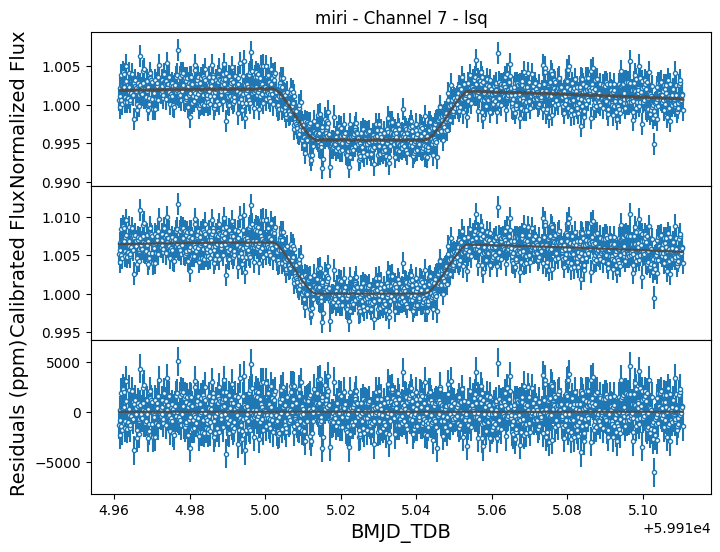

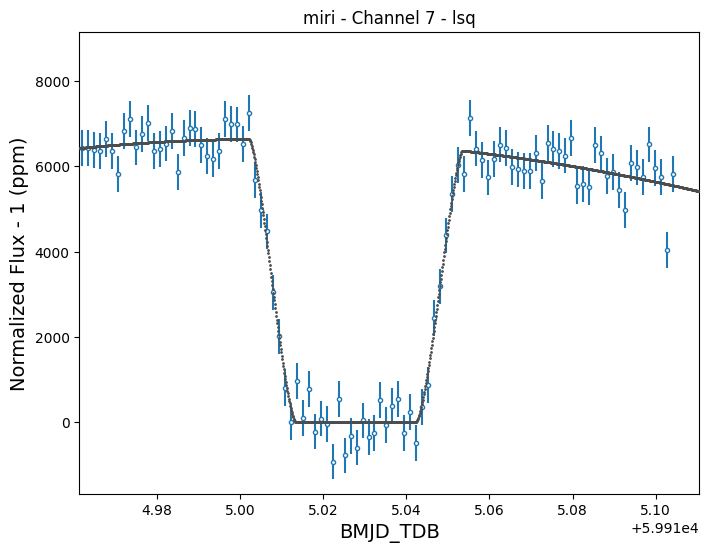

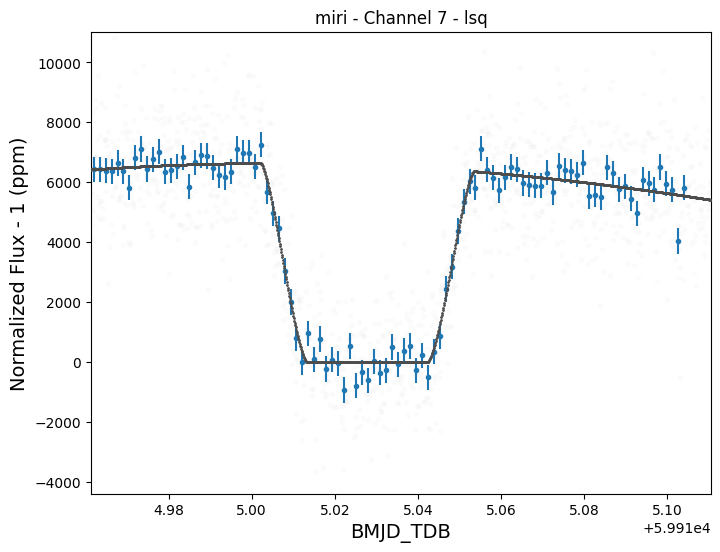

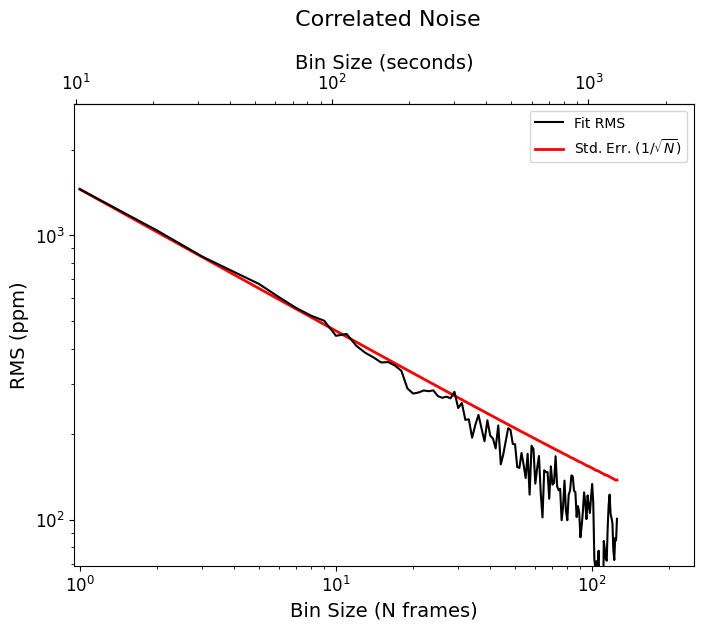

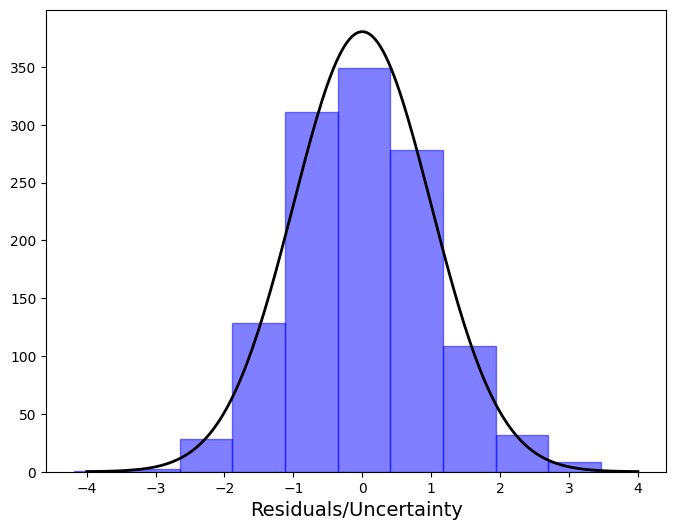

Completed lsq fit.
-------------------------


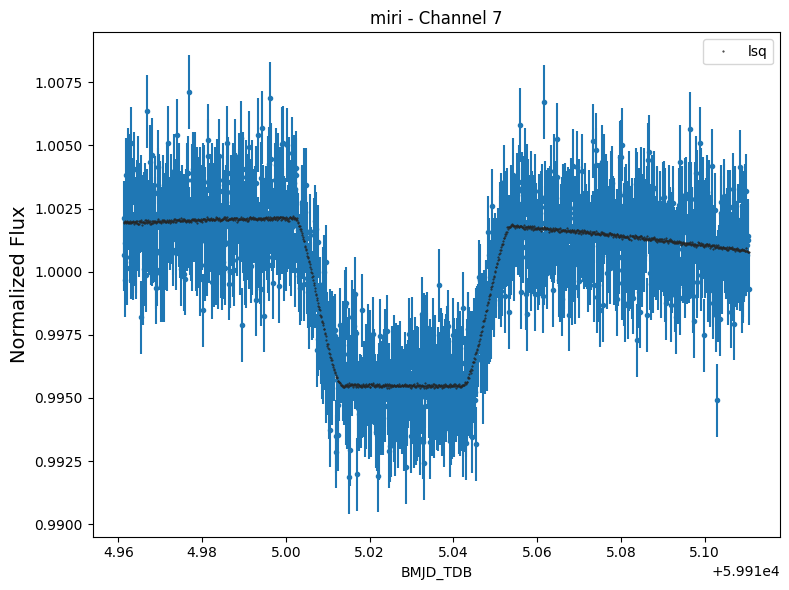

Saving results

Starting Channel 9 of 11

Starting lsq fit.
Starting lnprob: 6191.439419674819
Current lnprob =  6213.628401904715
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6213.628401904715
       x: [ 7.116e-03  5.101e-01 -2.205e-01  5.900e-01  8.400e-01
            3.053e-03 -6.938e-04  9.951e-01  9.461e-03  1.115e+00]
     nit: 5
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-1.604e-05 -1.076e-02 ...  6.693e-03 -2.957e-04]]
    nfev: 996

Ending lnprob: 6213.628401904715
Reduced Chi-squared: 1.007191153452427

LSQ RESULTS:
fp: 0.007115810401140298
AmpCos1: 0.5100635527504004
AmpSin1: -0.2205247330775978
u1: 0.590000005161842
u2: 0.8399999948381579
ypos: 0.0030531860469031097
ywidth: -0.0006938007637600877
c0: 0.9951381894449124
c1: 0.00946072540921449
scatt

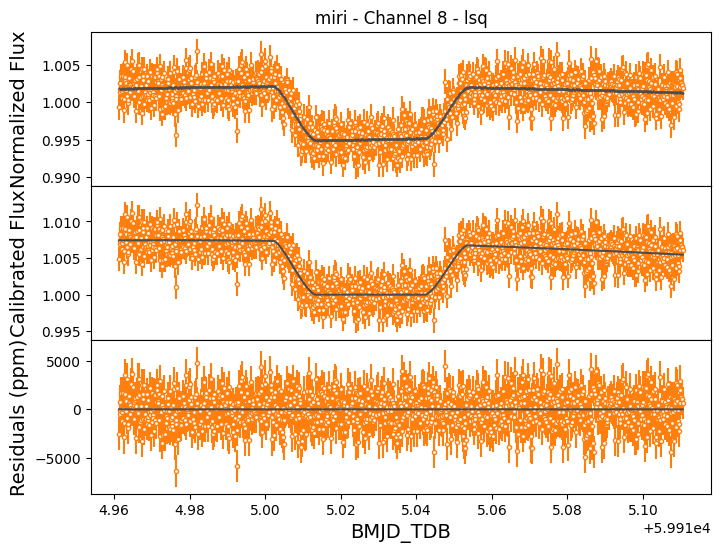

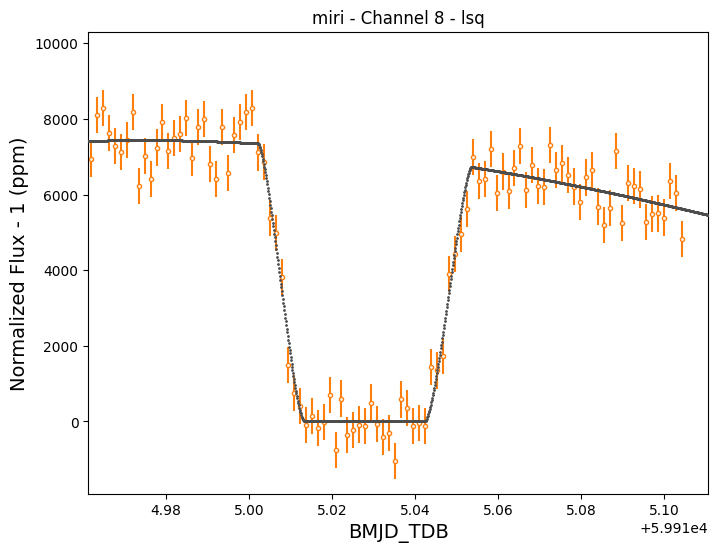

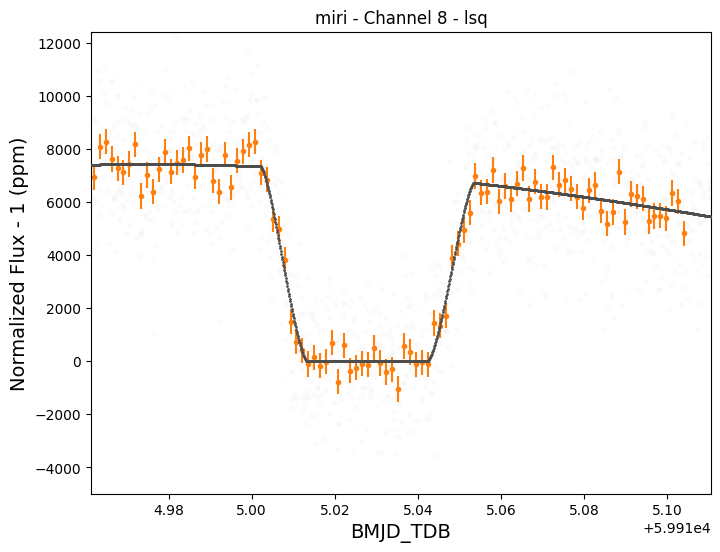

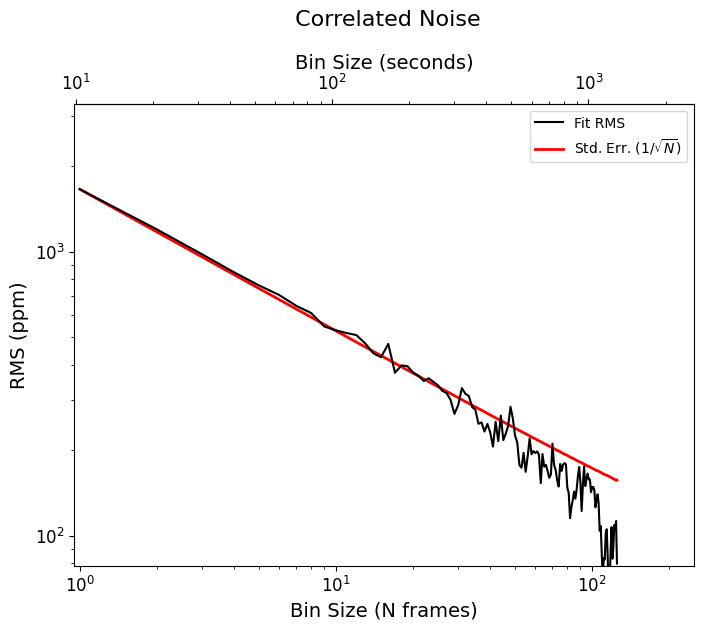

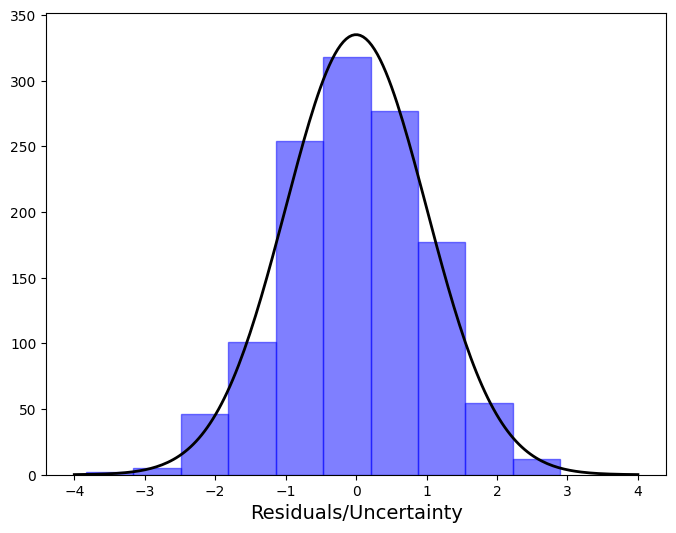

Completed lsq fit.
-------------------------


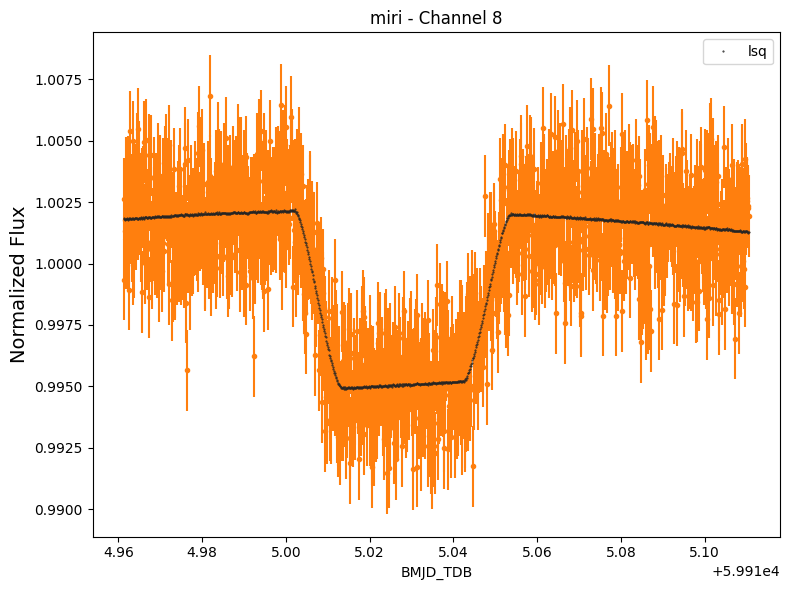

Saving results

Starting Channel 10 of 11

Starting lsq fit.
Starting lnprob: 6087.7639691799095
Current lnprob =  6097.949525495263
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6097.949525495263
       x: [ 7.475e-03  9.591e-01 -4.285e-02  5.900e-01  8.400e-01
           -7.342e-03  1.490e-02  9.950e-01 -1.348e-03  1.109e+00]
     nit: 8
   direc: [[ 1.550e-04  2.343e-01 ... -9.860e-04 -1.997e-03]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-4.377e-05 -3.348e-02 ... -7.110e-03 -5.189e-04]]
    nfev: 1744

Ending lnprob: 6097.949525495263
Reduced Chi-squared: 1.0080620171686305

LSQ RESULTS:
fp: 0.007474730855499958
AmpCos1: 0.9591235385570186
AmpSin1: -0.042847883519101154
u1: 0.5900000057614041
u2: 0.8399999942385958
ypos: -0.007341783092329853
ywidth: 0.014899196929385669
c0: 0.9949997009246642
c1: -0.00134847017997749

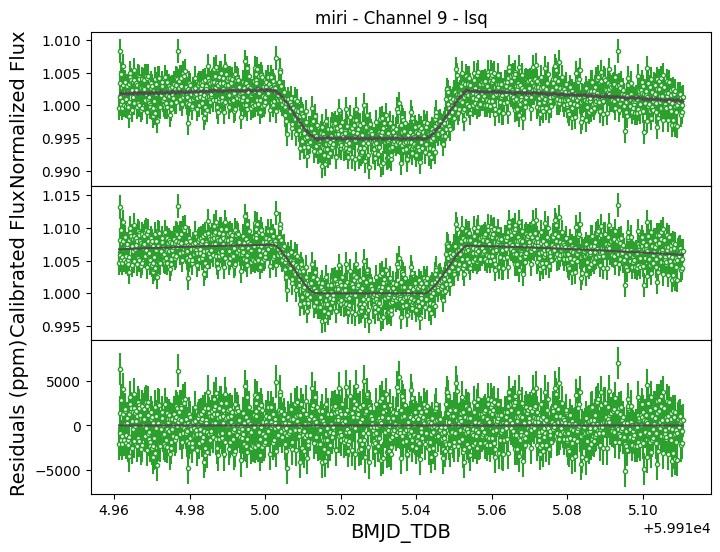

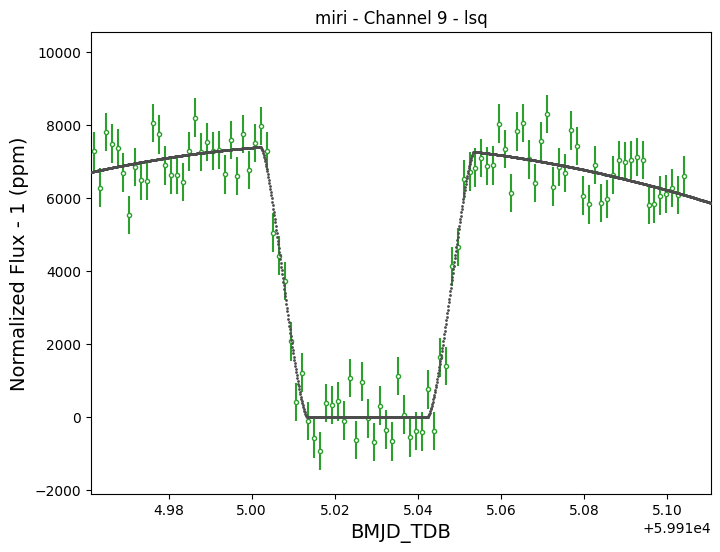

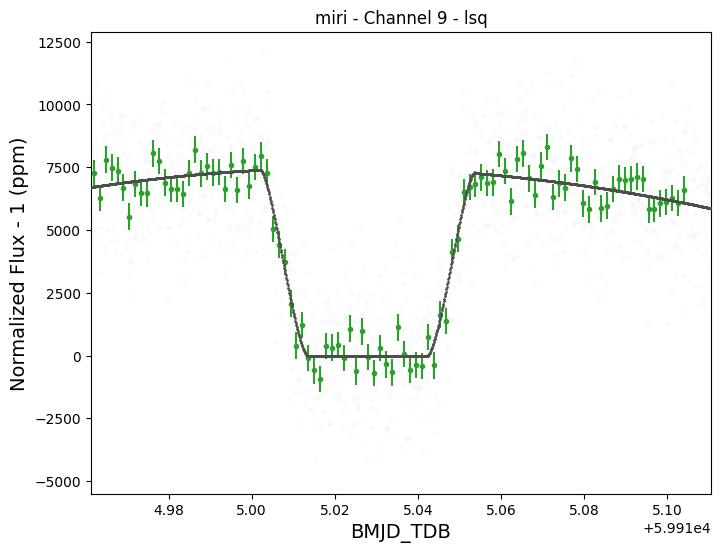

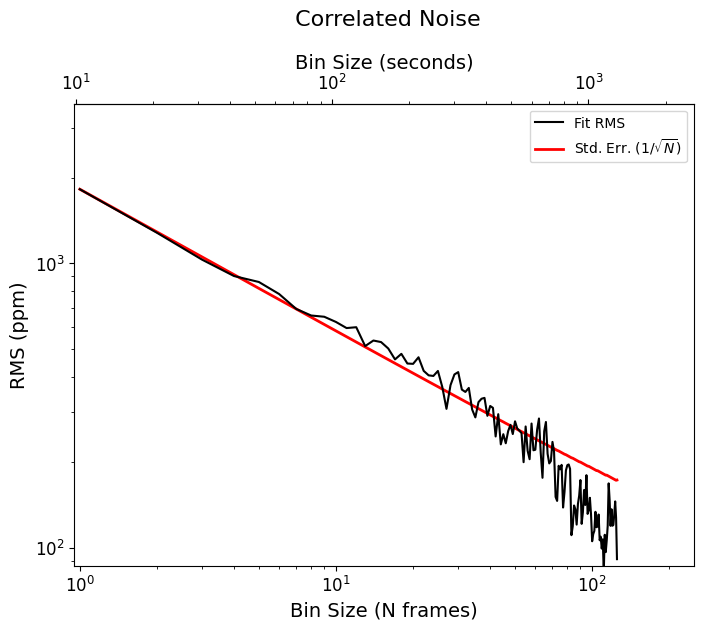

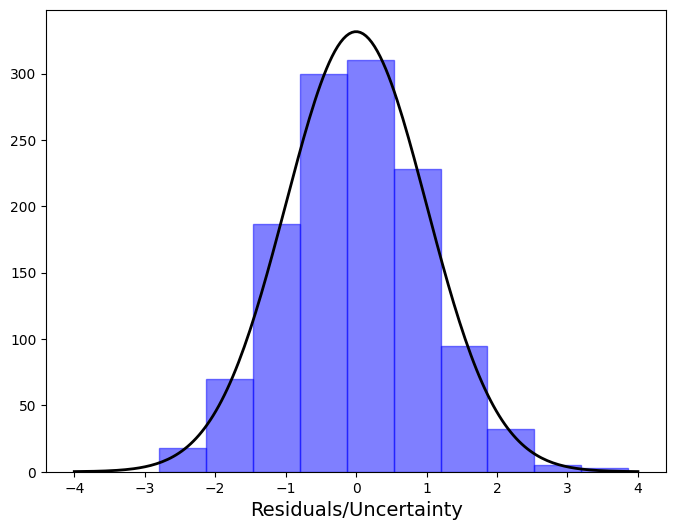

Completed lsq fit.
-------------------------


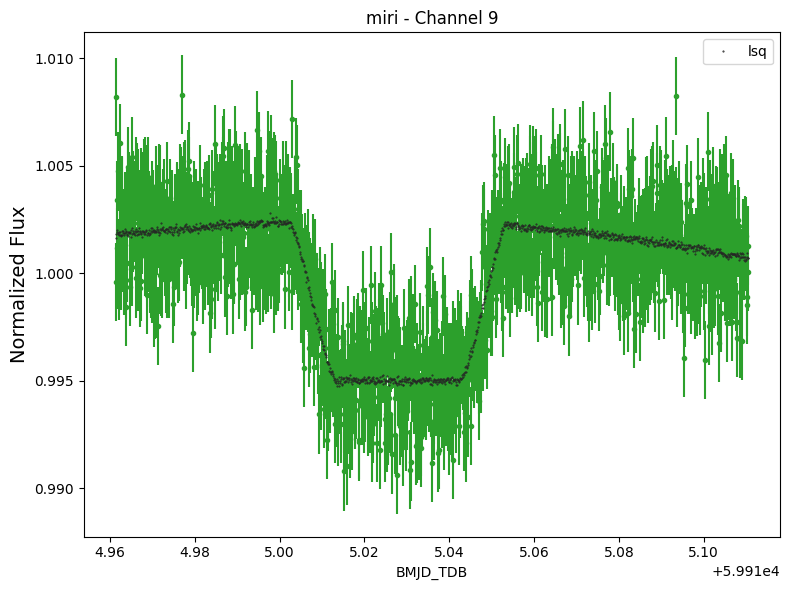

Saving results

Starting Channel 11 of 11

Starting lsq fit.
Starting lnprob: 5805.008372874467
Current lnprob =  5816.202758955876
Verbose lsq results:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -5816.202758955876
       x: [ 6.842e-03  1.929e-01 -1.580e-02  5.900e-01  8.400e-01
            4.692e-03  1.479e-02  9.951e-01 -1.342e-03  1.136e+00]
     nit: 5
   direc: [[-2.638e-04 -4.232e-01 ...  1.014e-04 -3.232e-03]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-1.407e-04  2.322e-02 ... -3.217e-04 -6.262e-04]]
    nfev: 968

Ending lnprob: 5816.202758955876
Reduced Chi-squared: 1.007279601687825

LSQ RESULTS:
fp: 0.006841696381486013
AmpCos1: 0.19286060884486075
AmpSin1: -0.015797432629424287
u1: 0.5900000058946594
u2: 0.8399999941053405
ypos: 0.004692099653489662
ywidth: 0.014792993942544788
c0: 0.9951316505255042
c1: -0.0013424888205428274


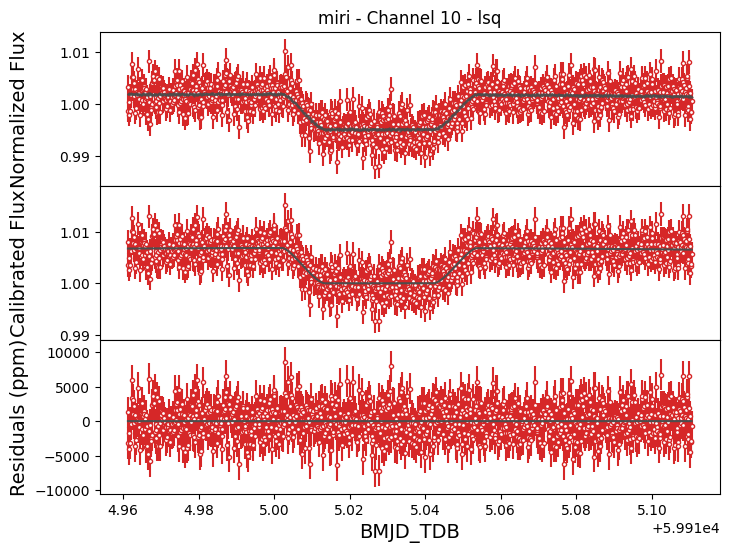

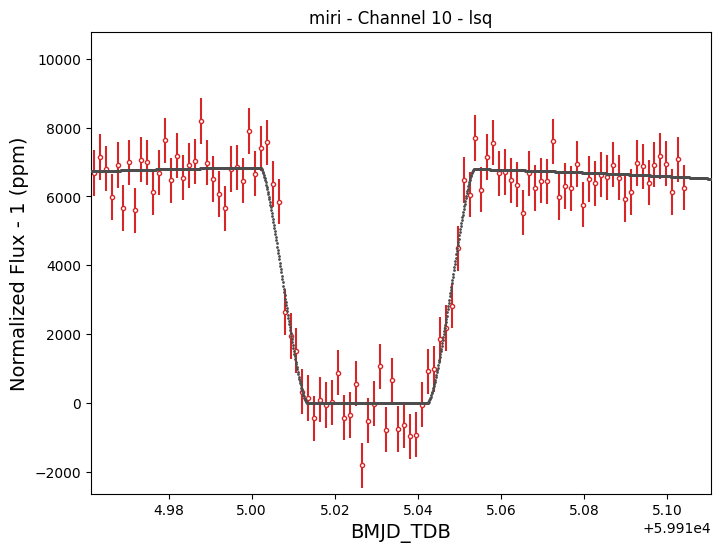

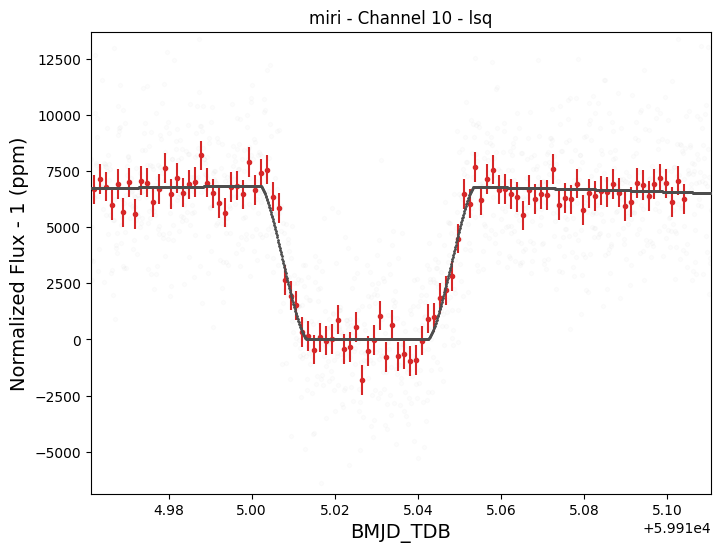

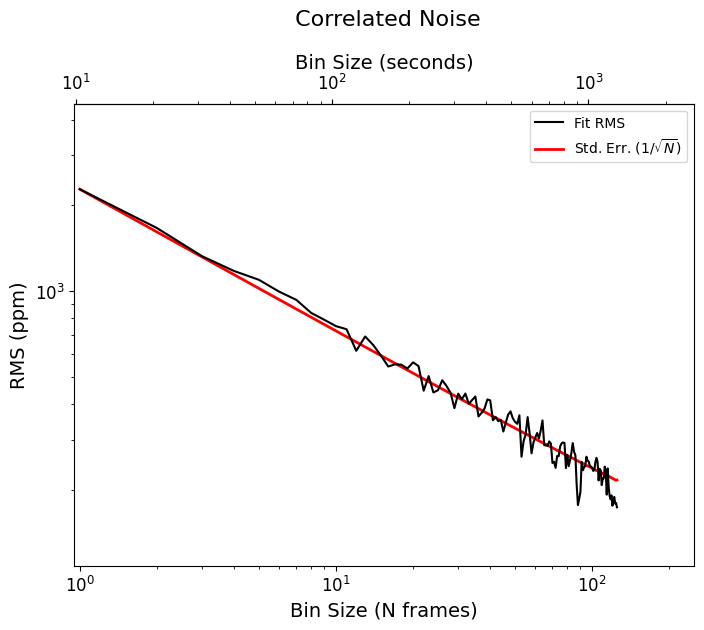

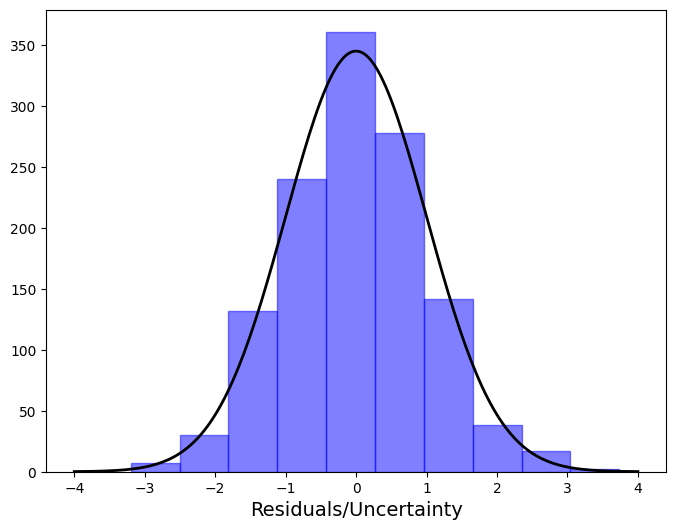

Completed lsq fit.
-------------------------


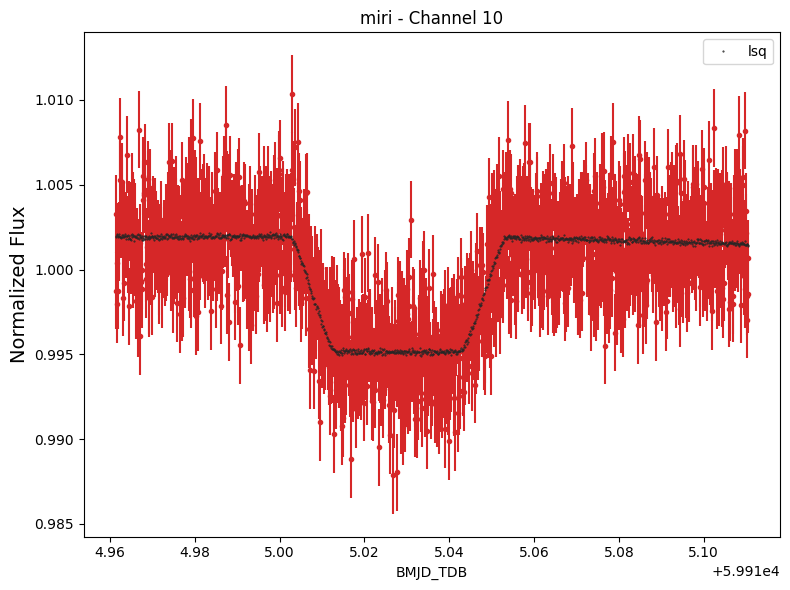

Saving results

Total time (min): 2.98


In [ ]:
s5_meta = eureka.S5_lightcurve_fitting.s5_fit.fitlc(eventlabel)

# Gathering together spectroscopic fits

Now that we've completed fits to the 11 spectroscopic channels, we want an easy way of seeing how different parameters vary with wavelength. Of particular interest is the eclipse depth (`fp`) — the variations in eclipse depth as a function of wavelength is called an emission spectrum and can be used to determine the presence and abundance of molecules in the atmosphere of an exoplanet. Because we only used the `lsq` optimization algorithm above, our emission spectrum will not have error bars. If you want to know what the spectrum looks like with error bars, you'll have to re-run your spectroscopic fits above using a sampler like dynesty.

## Setting the Stage 6 "Eureka! Control File" (ECF)

**This determines what will happen during Eureka!'s Stage 6**

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S6_template.ecf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

The most important parameters and their recommended settings are described below, but more context can be found on the [Eureka! documentation website](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-6).

1. Set `y_params` to `['fp']`. Eureka! is able to plot any of the `'free'` parameters from your fits as a function of wavelength, but the only one we're really interested in here is `fp`.
2. Set `y_scalars` to `[1e6]` so that units of ppm are used for a plot that is easier to read.
3. You can safely ignore the settings in the "Scale height parameters" chunk and "Model" chunk as they are not relevant for our purposes.
4. Set `topdir` to the same value as you used in your Stage 5 spectroscopic fits.

That's all we need to change for our purposes here, and all the other parameters can be left at their default settings.

In [ ]:
s6_ecf_contents = f"""
# Eureka! Control File for Stage 6: Spectra Plotting

# Stage 6 Documentation: https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-6

allapers        False # Run S6 on all of the apertures considered in S5? Otherwise will use newest output in the inputdir

# Plotting parameters
y_params        ['fp']  # The parameter name as entered in your EPF file in Stage 5. rp^2, 1/r1, 1/r4, fn (nightside flux), pc_amp (phase curve amplitude), and pc_offset (phase curve offset), pc_amp2 (second order phase curve amplitude), and pc_offset2 (second order phase curve offset) are also permitted.
y_labels        [None, None, None, None, None, None]  # The formatted string you want on the y-label. Set to None to use the default formatting.
y_label_units   [None, None, None, None, None, None]  # The formatted string for the units you want on the y-label - e.g., (ppm), (seconds), '(days$^{-1})$', etc.. Set to None to automatically add any implied units from y_scalars (e.g. ppm), or set to '' to force no units.
y_scalars       [1e6]  # Can be used to convert to percent (100), ppm (1e6), etc.
x_unit          um  # Options include any measurement of light included in astropy.units.spectral (e.g. um, nm, Hz, etc.)

# Tabulating parameters
ncol            4  # The number of columns you want in your LaTeX formatted tables

# This section is relevant if isplots_S6>=3
# Scale height parameters (if you want a second copy of the plot with a second y-axis with units of scale height)
star_Rad        0.6506 # The radius of the star in units of solar radii
planet_Teq      1400   # The equilibrium temperature of the planet in units of Kelvin
planet_Mass     2      # The planet's mass in units of Jupiter masses (used to calculate surface gravity)
planet_Rad      None   # The planet's radius in units of Jupiter radii (used to calculate surface gravity); Set to None to use the average fitted radius
planet_mu       2.3    # The mean molecular mass of the atmosphere (in atomic mass units)
planet_R0       None   # The reference radius (in Jupiter radii) for the scale height measurement; Set to None to use the mean fitted radius

# Diagnostics
isplots_S6      5      # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
hide_plots      False  # If True, plots will automatically be closed rather than popping up

# Project directory
topdir          /content/drive/MyDrive/SSW2023/MIRI

# Model to plot underneath the fitted data points
model_spectrum  None   # Path to the model spectrum relative to topdir. Set to None if no model should be plotted.
model_x_unit    um     # Options include any measurement of light included in astropy.units.spectral (e.g. um, nm, Hz, etc.)
model_y_param   rp^2   # Follow the same format as y_params. If desired, can be rp if y_params is rp^2, or vice-versa.
model_y_scalar  1      # Indicate whether model y-values have already been scaled (e.g. write 1e6 if model_spectrum is in ppm)
model_zorder    0      # The zorder of the model on the plot (0 for beneath the data, 1 for above the data)
model_delimiter None   # Delimiter between columns. Typical options: None (for space), ',' for comma


# Directories relative to topdir

# Directories relative to topdir
inputdir        Stage5   # The folder containing the outputs from Eureka!'s S5 pipeline (will be overwritten if calling S5 and S6 sequentially)
outputdir       Stage6
# Fill this text block with the contents of the S6 ECF template from https://github.com/kevin218/Eureka/tree/main/demos/JWST
# and then adjust the values as described above

"""

with open(f'S6_{eventlabel}.ecf', 'w') as f:
    f.write(s6_ecf_contents)

## Running Eureka!'s Stage 6

The following cell will run Eureka!'s Stage 6 using the settings you defined above. Note that your ECF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The following stage should take &#8810;1 minute to complete on Google Colab.


Starting Stage 6: Light Curve Fitting

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage5/S5_2023-07-26_miri_run1/ap6_bg12/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage6/S6_2023-07-26_miri_run1/ap6_bg12/
Copying S6 control file
Plotting fp...


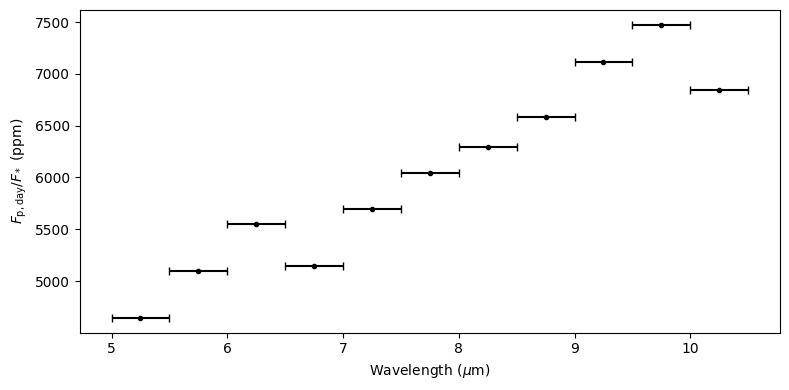

  Saving results as an astropy table
  Saving results as a LaTeX table
Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage6/S6_2023-07-26_miri_run1/ap6_bg12/S6_miri_ap6_bg12_LC.h5
Saving results

Total time (min): 0.03


In [ ]:
s6_meta = eureka.S6_planet_spectra.s6_spectra.plot_spectra(eventlabel)

As you can see from your emission spectrum, the eclipse depth increases with wavelength. This is generally true of thermal emission spectra because the emission spectrum is approximately a ratio of blackbody functions which increases with increasing wavelength. You should also see a decrease in the eclipse depth around 6.5 microns - this feature is indicative of water in the atmosphere of WASP-43b. In the next workshops, we'll learn how we can use forward models and retrievals to interpret transmission and/or emission spectra.